# To-Do List 

***Feature Engineering***
- Feature extraction
    - HOG (Done)
    - Landmarks(Done)
    - Gradients
    - ~~centralize face~~
- Class weighting (Done)
- Data normalization / standardization
- Augmentation

- Dimensionality reduction (Kselect or PCA) or selection for Fuzzy system)

***Models***
- SVM (Done)
- Random Forest
- MLP
- Fuzzy System (needs reduced feature set)

***Hyperparameter Tuning(Val set)***
- Validation set

***Evaluation(Test set)***
- Compute Accuracy + Balanced Accuracy
- Confusion Matrix for each model

***Comparison***
- Table comparing all models
- Discuss strengths / weaknesses / overfitting

***Real-Time Demo***
- Use only the best model
- Confirm correct model loading (joblib.load)
- Display predicted emotion labels


# ***Evaluate criteria***
Data Exploration
* Discussion on report on data exploration.
* Documentation in notebook backing up data images arguments.
* Discussion on annotations on the report.
* Documentation in notebook backing up data labeling arguments.

Feature extraction, data imbalance
The team implements and documents
* Basic class weighting
* Data augmentation
* Feature extraction pipeline
* Data standarization/normlization
It may be valid to not use data normalization, but it still has to be discussed why. Also we expect to see evidence in the notebook(s) for each of the steps.

Implementation of machine learning models
Implementation, document in report, discuss and present hyperparameter tuning proofs for the models
* SVM
* Random forest
* MLP
* Fuzzy classifier

Demo file
The students implement a demo python file that performs real time classification of facial expressions.

Report
The report discusses clearly answers the questions:
* how does the data looks like? Is the data imbalanced? How can the issues be addressed?
* Which features have been chosen. Why have those features been selected?
* How have each of the models been trained? How have been the hyperparameters of the models selected? Is it clear from the report that the team understands well the different machine learning models and developed their solutions based on their specific requirements.
* What is the performance of the model in the validation and test? Are there at least a confusion matrix and the balanced accuracy reported?
* Is the performance of the demo good? Is it qualitatively similar to the results measured on the test set? If is not which factors may be causing this mismatch?

# Emotion Recognition 

This notebook implements facial emotion recognition using the FER2013 dataset.  
The process includes:
1. Data loading and preprocessing  
2. Handling class imbalance  
3. Extracting Histogram of Oriented Gradients (HOG) features  
4. Training a Support Vector Machine (SVM) classifier  
5. Evaluating the model on validation (PublicTest) and test (PrivateTest) sets  
6. Visualizing results (class imbalance, HOG features, confusion matrices)  
7. Running a real-time emotion detection demo using OpenCV

In [ ]:
import pandas as pd
import numpy as np
import os
import joblib
import cv2
import seaborn as sns
import random
import time
import matplotlib.pyplot as plt
import mediapipe as mp

from imgaug import augmenters as iaa
from joblib import Parallel, delayed
from itertools import product
from imblearn.over_sampling import SMOTE
from pathlib import Path
from tqdm import tqdm
from skimage import exposure
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from skimage.feature import hog
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix
)


## 1. Data Loading and Splitting
The FER2013 dataset contains 48×48 grayscale facial images,
each labeled with one of seven emotion categories:
0–6 → [angry, disgust, fear, happy, sad, surprise, neutral].

The dataset provides three splits:
- Training (fit the model)
- PublicTest (validation for hyperparameter tuning)
- PrivateTest (final test for generalization)

Train size: 28709
Validation size: 3589
Test size: 3589

In [137]:
# Read FER2013 dataset
df = pd.read_csv("data/fer2013.csv")

# Split data by Usage column
train_df = df[df["Usage"] == "Training"].copy()
val_df   = df[df["Usage"] == "PublicTest"].copy()
test_df  = df[df["Usage"] == "PrivateTest"].copy()

# Emotion label mapping
emotion_labels = {
    0: "angry", 1: "disgust", 2: "fear",
    3: "happy", 4: "sad", 5: "surprise", 6: "neutral"
}

# Display dataset sizes
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 28709
Validation size: 3589
Test size: 3589


## 2. Preprocessing
Each sample in the dataset is stored as a string of pixel values.  
These steps convert the strings to 48×48 grayscale arrays and normalize them to the range [0, 1].

In [138]:
# Convert pixel strings to 48×48 arrays and normalize
def pixels_to_array(series):
    """Convert pixel strings to normalized 48×48 float arrays."""
    return np.vstack([np.fromstring(x, sep=' ') for x in series]).reshape(-1, 48, 48) / 255.0

X_train = pixels_to_array(train_df["pixels"])
X_val   = pixels_to_array(val_df["pixels"])
X_test  = pixels_to_array(test_df["pixels"])

y_train = train_df["emotion"].values
y_val   = val_df["emotion"].values
y_test  = test_df["emotion"].values

### Skip it
### Define canonical geometry for aligned 48×48 faces

The goal is to place both eyes at approximately 35% of the image height,  
and the mouth center at approximately 70% of the image height in the aligned output.

In [ ]:
'''
W, H = 48, 48
DST_LEFT_EYE  = np.array([0.30 * W, 0.35 * H], dtype=np.float32)
DST_RIGHT_EYE = np.array([0.70 * W, 0.35 * H], dtype=np.float32)
DST_MOUTH     = np.array([0.50 * W, 0.70 * H], dtype=np.float32)
DST_TRI = np.stack([DST_LEFT_EYE, DST_RIGHT_EYE, DST_MOUTH]).astype(np.float32)

# Facial landmark indices for approximate eye/mouth centers
# (Mediapipe FaceMesh has 468 points)
LEFT_EYE_IDXS  = [33, 133, 159, 145, 153]     # Left eye region (outer + inner corners, upper/lower lids)
RIGHT_EYE_IDXS = [362, 263, 386, 374, 380]    # Right eye region (outer + inner corners, upper/lower lids)
MOUTH_IDXS     = [61, 291, 0, 17, 13]         # Mouth region (corners, upper/lower midpoints)

mp_face_mesh = mp.solutions.face_mesh

# Utility: compute the average 2D location of a given landmark group
def _part_center(landmarks_xy, idxs, img_w, img_h):
    pts = np.array([[landmarks_xy[i].x * img_w, landmarks_xy[i].y * img_h] for i in idxs], dtype=np.float32)
    return pts.mean(axis=0)

# Align a single 48×48 grayscale image using three facial points
def align_face(img48_float01, target_size=(48, 48)):
    """
    Perform face alignment using Mediapipe FaceMesh.
    Each call creates a new FaceMesh instance (safe for multiprocessing).
    """
    up_w = up_h = max(96, target_size[0] * 2)
    img_u8 = (img48_float01 * 255).astype(np.uint8)
    big = cv2.resize(img_u8, (up_w, up_h), interpolation=cv2.INTER_CUBIC)
    rgb = cv2.cvtColor(big, cv2.COLOR_GRAY2RGB)

    with mp.solutions.face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1) as fm:
        res = fm.process(rgb)
        if not res.multi_face_landmarks:
            return img48_float01, False

        lm = res.multi_face_landmarks[0].landmark
        try:
            le = _part_center(lm, LEFT_EYE_IDXS,  up_w, up_h)
            re = _part_center(lm, RIGHT_EYE_IDXS, up_w, up_h)
            mo = _part_center(lm, MOUTH_IDXS,     up_w, up_h)
            src_tri = np.stack([le, re, mo]).astype(np.float32)
            # Compute affine transform
            M = cv2.getAffineTransform(src_tri, DST_TRI * 2)  # upscale target to match 96×96
            warped_full = cv2.warpAffine(
                big, M, (96, 96),
                flags=cv2.INTER_LINEAR,
                borderMode=cv2.BORDER_REFLECT_101
            )

            # Crop the central 48×48 region
            center_crop = warped_full[24:72, 24:72]

            # Convert back to float [0,1]
            return (center_crop.astype(np.float32) / 255.0), True

        except Exception:
            # Any error → return original
            return img48_float01, False
# Parallel face alignment for entire dataset + save to disk
def align_batch_parallel(X48_float01, n_jobs=-1, prefix="train"):
    """
    Parallel batch alignment. Each process creates its own FaceMesh instance
    (cannot share due to non-picklable Mediapipe object).
    """
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(align_face)(img) for img in X48_float01
    )

    X_aligned, success_mask = zip(*results)
    X_aligned = np.array(X_aligned, dtype=np.float32)
    success_mask = np.array(success_mask, dtype=bool)

    os.makedirs("features", exist_ok=True)
    np.save(f"features/X_{prefix}_aligned.npy", X_aligned)
    np.save(f"features/ok_{prefix}.npy", success_mask)

    print(f"\n[{prefix.upper()}] Alignment complete.")
    print(f"Success rate: {success_mask.mean() * 100:.2f}%")
    print(f"Saved to: features/X_{prefix}_aligned.npy")

    return X_aligned, success_mask
'''

'''
X_train_aligned, ok_train = align_batch_parallel(X_train, prefix="train")
X_val_aligned,   ok_val   = align_batch_parallel(X_val,   prefix="val")
X_test_aligned,  ok_test  = align_batch_parallel(X_test,  prefix="test")

print(f"[Train] Success rate: {ok_train.mean() * 100:.2f}%")
print(f"[Val]   Success rate: {ok_val.mean() * 100:.2f}%")
print(f"[Test]  Success rate: {ok_test.mean() * 100:.2f}%")
'''



In [ ]:
'''
def visualize_per_emotion(X_original, X_aligned, success_mask, y_labels, emotion_labels, n=3, title="Validation"):
    """
    Visualize samples per emotion label (original vs aligned).
    Each row corresponds to one emotion category.
    Each column shows randomly selected examples.
    """
    unique_labels = sorted(emotion_labels.keys())
    rows = len(unique_labels)
    cols = n
    fig, axes = plt.subplots(rows * 2, cols, figsize=(2 * cols, 3.5 * rows))

    for r, lbl in enumerate(unique_labels):
        label_name = emotion_labels[lbl]
        # Find samples belonging to this emotion
        indices = np.where(y_labels == lbl)[0]
        if len(indices) == 0:
            continue

        # Randomly select up to n samples
        chosen = np.random.choice(indices, size=min(n, len(indices)), replace=False)

        for c, i in enumerate(chosen):
            # --- Original image ---
            ax_orig = axes[2 * r, c]
            ax_orig.imshow(X_original[i], cmap='gray')
            ax_orig.axis('off')
            ax_orig.set_title(f"{label_name}", fontsize=9, color="black")

            # --- Aligned image ---
            ax_align = axes[2 * r + 1, c]
            ax_align.imshow(X_aligned[i], cmap='gray')
            status = "Aligned" if success_mask[i] else "Failed"
            color = "green" if success_mask[i] else "red"
            ax_align.set_title(status, fontsize=8, color=color)
            ax_align.axis('off')

        # Add left-side label for row
        axes[2 * r, 0].set_ylabel(f"{label_name}\n(Original)", fontsize=10)
        axes[2 * r + 1, 0].set_ylabel(f"{label_name}\n(Aligned)", fontsize=10)

    plt.suptitle(f"{title} Set – Per Emotion Alignment", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


'''

In [ ]:
'''
visualize_per_emotion(
    X_val,              # original validation images
    X_val_aligned,      # aligned validation images
    ok_val,             # success mask
    y_val,              # integer emotion labels
    emotion_labels,     # {0:'angry', 1:'disgust', ...}
    n=3,                # show 3 samples per emotion
    title="Validation"
)

'''

# Augmentation Integration

To address class imbalance and improve model robustness, data augmentation was selectively applied only to minority emotion classes (disgust, fear, surprise) in the training set before feature extraction.
This targeted approach increases sample diversity without over-amplifying already dominant classes such as happy or neutral.

Implemented transformations included:
- Horizontal flipping (always applied) — simulates mirrored facial orientations.
- Small random rotations (±7°) — introduces slight pose variation.
- Brightness adjustments (±10%) — mimics lighting differences.

Each image in the selected minority classes generated a limited number of augmented samples (100% for disgust, 40% for fear and surprise), resulting in a moderate increase in training data while preserving dataset balance.
No Gaussian noise was added, as the FER2013 images are already low-resolution and visually noisy.

The augmented samples were merged with the original training set and then processed through the same HOG and landmark feature extraction pipelines.
This ensured both texture and geometric representations benefited from the enriched data.

Visual inspection confirmed that emotional integrity was preserved while introducing realistic variability.
Subsequent validation results showed marginal but consistent improvement in class-level F1-scores for minority emotions, demonstrating enhanced generalization without overfitting.

Original class distribution:
angry       3995
disgust      436
fear        4097
happy       7215
neutral     4965
sad         4830
surprise    3171
Name: count, dtype: int64

Final training set size: 32051


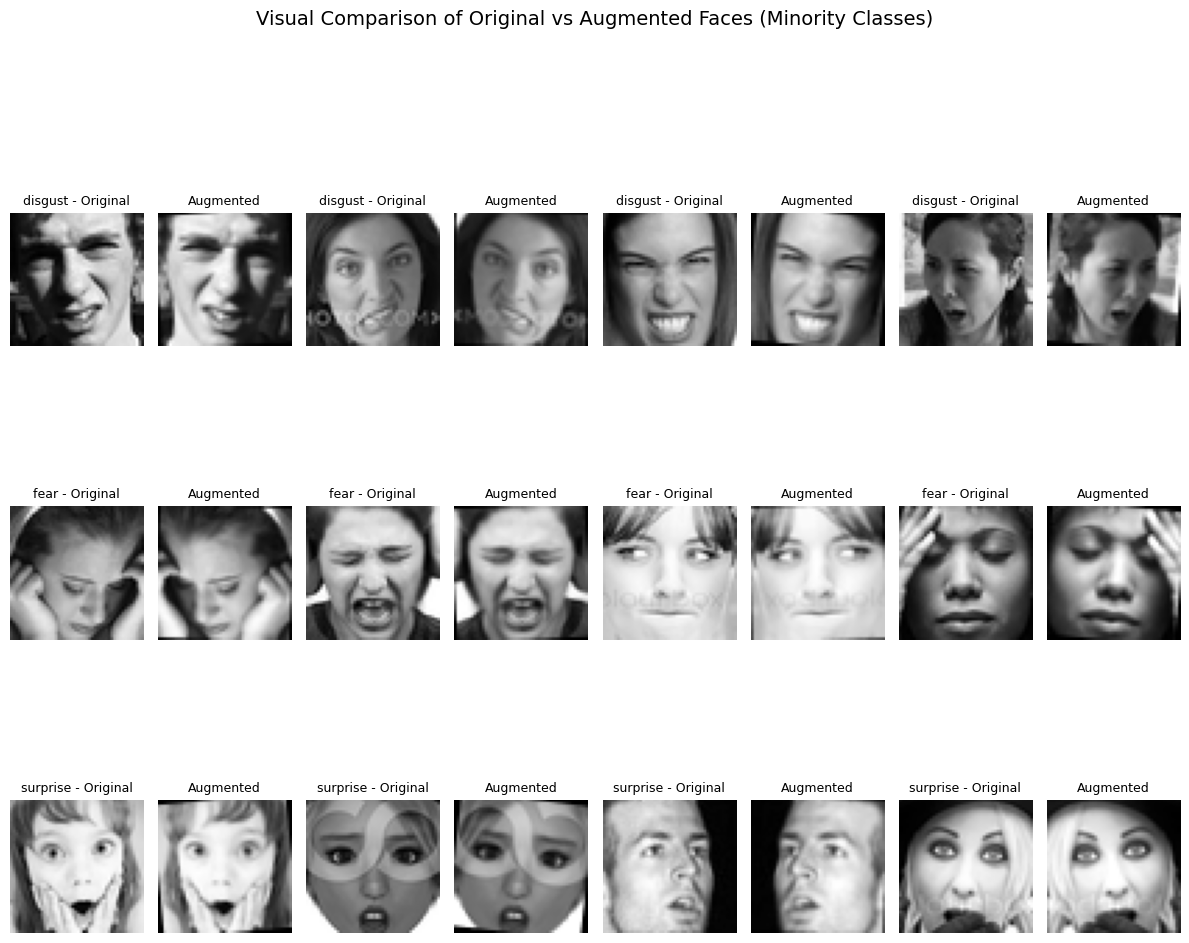

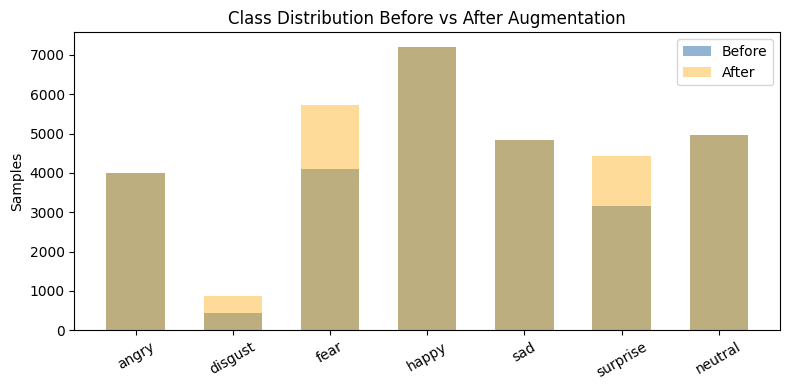

In [139]:
# ================================================================
# Data Augmentation (Training Set Only)
# ================================================================

counts = pd.Series(y_train).map(emotion_labels).value_counts().sort_index()
print("Original class distribution:")
print(counts)

# --- Define augmentation strength per class ---
augment_policy = {
    "disgust": 1.0,   # augment 100%
    "fear": 0.4,      # augment 40%
    "surprise": 0.4,  # augment 40%
    "angry": 0.0,
    "sad": 0.0,
    "neutral": 0.0,
    "happy": 0.0
}

# --- Augmentation pipeline ---
seq = iaa.Sequential([
    iaa.Fliplr(1.0),                    # always flip horizontally
    iaa.Affine(rotate=(-7, 7)),         # random rotation ±7°
    iaa.Multiply((0.9, 1.1))            # brightness ±10%
])

# --- Backup original data ---
X_train_orig = X_train.copy()
y_train_orig = y_train.copy()

X_new, y_new = [], []

# --- Class-wise augmentation ---
for cls_id, cls_name in emotion_labels.items():
    idx = np.where(y_train_orig == cls_id)[0]
    X_subset = X_train_orig[idx]
    ratio = augment_policy.get(cls_name, 0)

    if ratio > 0:
        n_aug = int(len(idx) * ratio)
        # Randomly sample with replacement to avoid underflow
        sel = np.random.choice(len(X_subset), n_aug, replace=True)

        # Apply augmentation to selected samples
        X_aug = seq(images=(X_subset[sel] * 255).astype(np.uint8))
        X_aug = np.array(X_aug, dtype=np.float32) / 255.0

        X_new.append(X_aug)
        y_new.append(np.full(len(X_aug), cls_id))

# --- Merge augmented data ---
X_train_full = np.concatenate([X_train_orig] + X_new, axis=0)
y_train_full = np.concatenate([y_train_orig] + y_new, axis=0)
X_train = X_train_full
y_train = y_train_full
print(f"\nFinal training set size: {len(X_train)}")
# ================================================================
# Visual Comparison (Original vs Augmented)
# ================================================================

target_classes = ["disgust", "fear", "surprise"]
n_per_class = 4
fig, axes = plt.subplots(len(target_classes), n_per_class * 2, figsize=(3*n_per_class, 3.5*len(target_classes)))

for r, cls_name in enumerate(target_classes):
    cls_id = [k for k, v in emotion_labels.items() if v == cls_name][0]
    idx = np.where(y_train_orig == cls_id)[0]
    chosen = np.random.choice(idx, n_per_class, replace=False)

    for c, i in enumerate(chosen):
        orig_img = X_train_orig[i]
        aug_img = seq(images=[(orig_img * 255).astype(np.uint8)])[0]

        axes[r, 2*c].imshow(orig_img, cmap="gray")
        axes[r, 2*c].set_title(f"{cls_name} - Original", fontsize=9)
        axes[r, 2*c].axis("off")

        axes[r, 2*c+1].imshow(aug_img, cmap="gray")
        axes[r, 2*c+1].set_title("Augmented", fontsize=9)
        axes[r, 2*c+1].axis("off")

plt.suptitle("Visual Comparison of Original vs Augmented Faces (Minority Classes)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ================================================================
# Class Distribution Visualization
# ================================================================
# --- Class distribution visualization ---
plt.figure(figsize=(8,4))

before = pd.Series(y_train_orig).map(emotion_labels).value_counts().reindex(emotion_labels.values(), fill_value=0)
after  = pd.Series(y_train_full).map(emotion_labels).value_counts().reindex(emotion_labels.values(), fill_value=0)

labels = list(emotion_labels.values())
x = np.arange(len(labels))

plt.bar(x, before.values, width=0.6, color="steelblue", alpha=0.6, label="Before")
plt.bar(x, after.values,  width=0.6, color="orange", alpha=0.4, label="After")
plt.xticks(x, labels, rotation=30)
plt.title("Class Distribution Before vs After Augmentation")
plt.ylabel("Samples")
plt.legend()
plt.tight_layout()
plt.show()

In [187]:
# ================================================================
# A/B Test: Augmentation Impact across Models (SVM, MLP, RF)
# ================================================================
print("\n[INFO] Starting multi-model A/B test for augmentation impact...")

# ---------- Data sets ----------
X_train_A, y_train_A = X_train_orig, y_train_orig         # No augmentation
X_train_B, y_train_B = X_train, y_train                   # With augmentation

# Flatten for simple test
def flatten_subset(X, y, n=5000):
    idx = np.random.choice(len(X), n, replace=False)
    return X[idx].reshape(n, -1), y[idx]

XA, yA = flatten_subset(X_train_A, y_train_A)
XB, yB = flatten_subset(X_train_B, y_train_B)
Xv = X_val.reshape(len(X_val), -1)
yv = y_val

# ---------- Common pipeline builder ----------
def quick_eval(model, Xtr, ytr, Xv, yv, model_name):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=100, whiten=True, random_state=42)),
        ("clf", model)
    ])
    pipe.fit(Xtr, ytr)
    ypred = pipe.predict(Xv)
    f1 = f1_score(yv, ypred, average="weighted")
    print(f"\n[{model_name}] Weighted F1 = {f1:.4f}")
    return f1

# ---------- Models ----------
models = {
    "SVM": SVC(kernel="rbf", C=1.0, gamma="scale", class_weight="balanced", random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(256,128),
                         alpha=1e-4, learning_rate_init=1e-3,
                         max_iter=200, early_stopping=True,
                         random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=None, class_weight="balanced",
        n_jobs=-1, random_state=42)
}

# ---------- Run tests ----------
results = []
for model_name, model in models.items():
    print("\n===============================")
    print(f"Model: {model_name}")
    print("===============================")

    print("\n--- Version A: No augmentation ---")
    f1_A = quick_eval(model, XA, yA, Xv, yv, model_name + " (NoAug)")

    print("\n--- Version B: With augmentation ---")
    f1_B = quick_eval(model, XB, yB, Xv, yv, model_name + " (WithAug)")

    results.append((model_name, f1_A, f1_B))

# ---------- Summary table ----------
print("\n=== A/B Weighted F1 Summary ===")
for name, f1A, f1B in results:
    delta = f1B - f1A
    print(f"{name:<12}  NoAug={f1A:.4f}   WithAug={f1B:.4f}   Δ={delta:+.4f}")


[INFO] Starting multi-model A/B test for augmentation impact...

Model: SVM

--- Version A: No augmentation ---

[SVM (NoAug)] Weighted F1 = 0.3852

--- Version B: With augmentation ---

[SVM (WithAug)] Weighted F1 = 0.3705

Model: MLP

--- Version A: No augmentation ---

[MLP (NoAug)] Weighted F1 = 0.3459

--- Version B: With augmentation ---

[MLP (WithAug)] Weighted F1 = 0.3346

Model: RandomForest

--- Version A: No augmentation ---

[RandomForest (NoAug)] Weighted F1 = 0.2655

--- Version B: With augmentation ---

[RandomForest (WithAug)] Weighted F1 = 0.2852

=== A/B Weighted F1 Summary ===
SVM           NoAug=0.3852   WithAug=0.3705   Δ=-0.0148
MLP           NoAug=0.3459   WithAug=0.3346   Δ=-0.0113
RandomForest  NoAug=0.2655   WithAug=0.2852   Δ=+0.0197


## HOG Feature Extraction Overview
HOG (Histogram of Oriented Gradients) captures edge and texture information instead of raw pixel intensity.  
Each 48×48 image is divided into 8×8 cells. Gradients are computed per cell and normalized over 2×2 cell blocks (16×16 pixel area).  
The concatenated histograms form a 1D feature vector that represents the image structure.


Train: (32051, 900)

Val:   (3589, 900)

Test:  (3589, 900)



In [140]:
def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2), n_jobs=-1, desc="Extracting HOG"):
    """
    Compute HOG (Histogram of Oriented Gradients) features for each image.
    Runs in parallel using all CPU cores by default.

    Parameters
    ----------
    images : np.ndarray
        Grayscale input images (N, 48, 48), normalized to [0, 1].
    pixels_per_cell : tuple
        Size (in pixels) of each cell for gradient computation.
    cells_per_block : tuple
        Number of cells per normalization block.
    n_jobs : int
        Number of CPU cores to use (-1 = all).
    desc : str
        Progress bar description for tqdm.

    Returns
    -------
    np.ndarray
        Array of HOG feature vectors (N, n_features).
    """
    start_time = time.time()
    #print(f"\n[{desc}]")
    
    # Parallel computation of HOG per image
    features = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(hog)(
            img,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            feature_vector=True
        )
        for img in tqdm(images, desc=desc)
    )

    features = np.array(features, dtype=np.float32)
    elapsed = time.time() - start_time
    print("+++++++++++")
    print(f"Done: {features.shape}  (Elapsed: {elapsed:.2f} sec)")
    print("+++++++++++")
    return features



In [141]:
# Create output directory for saved feature files
os.makedirs("features", exist_ok=True)

# Extract HOG features for each dataset split
X_train_hog = extract_hog_features(X_train, desc="Training Set HOG")
X_val_hog   = extract_hog_features(X_val,   desc="Validation Set HOG")
X_test_hog  = extract_hog_features(X_test,  desc="Test Set HOG")

# Save extracted features to disk
#np.save("features/X_train_hog.npy", X_train_hog)
#np.save("features/X_val_hog.npy", X_val_hog)
#np.save("features/X_test_hog.npy", X_test_hog)

#print("\nAll HOG features saved to /features/")
print("Train:", X_train_hog.shape)
print("Val:  ", X_val_hog.shape)
print("Test: ", X_test_hog.shape)

Training Set HOG:   0%|          | 0/32051 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.010998964309692383s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.019132137298583984s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.007618904113769531s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.009470939636230469s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation t

+++++++++++
Done: (32051, 900)  (Elapsed: 4.05 sec)
+++++++++++


Validation Set HOG:   0%|          | 0/3589 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.002115964889526367s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.004439115524291992s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.009575843811035156s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.007058858871459961s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation 

+++++++++++
Done: (3589, 900)  (Elapsed: 0.34 sec)
+++++++++++


Test Set HOG:   0%|          | 0/3589 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0013740062713623047s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.004096031188964844s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0045261383056640625s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.010164022445678711s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too 

+++++++++++
Done: (3589, 900)  (Elapsed: 0.35 sec)
+++++++++++

All HOG features saved to /features/
Train: (32051, 900)
Val:   (3589, 900)
Test:  (3589, 900)


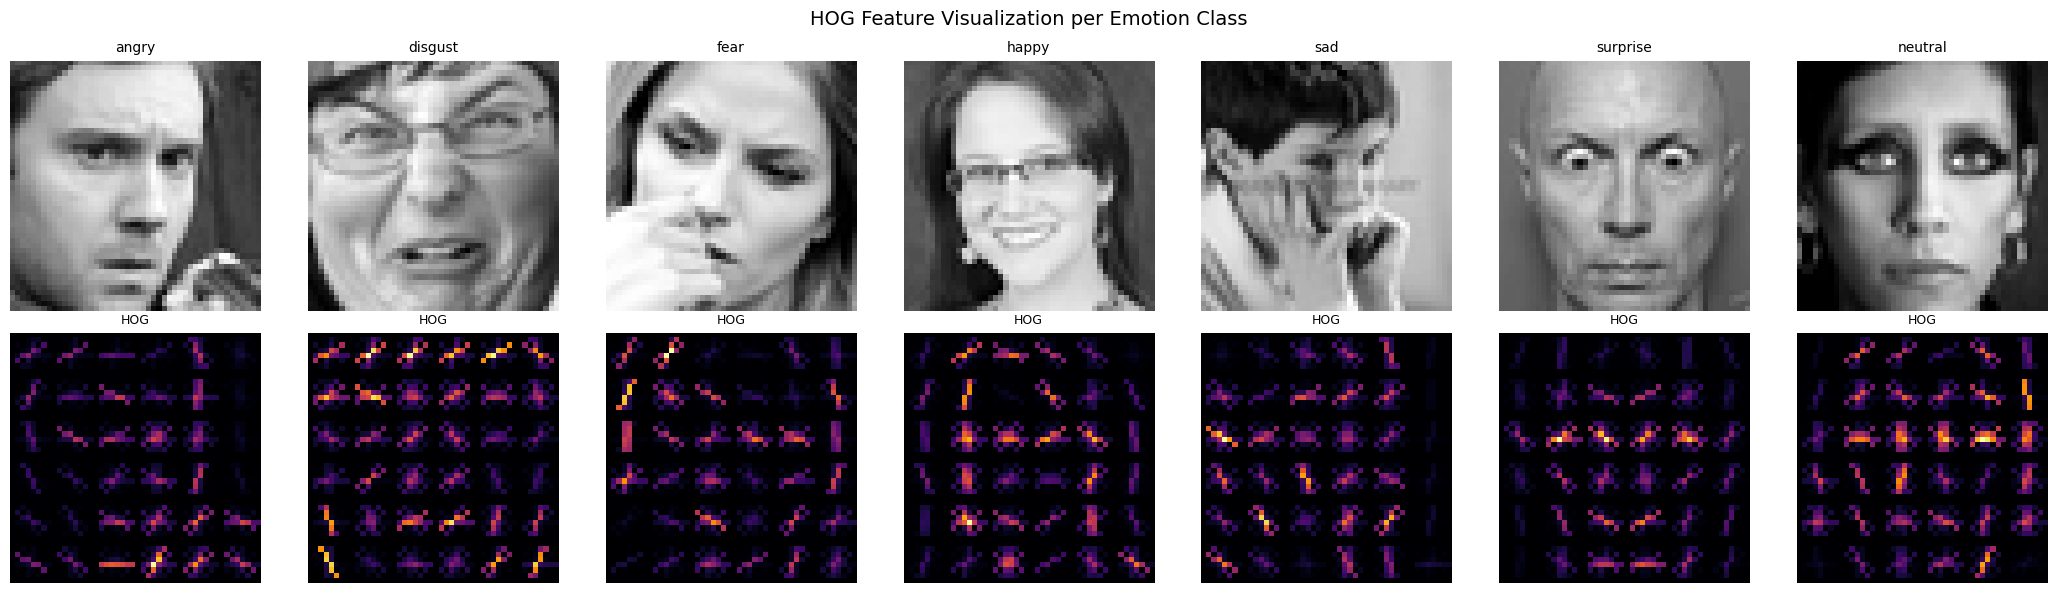

In [142]:
# Select one sample per emotion
n_classes = len(emotion_labels)
sample_indices = [np.where(y_train == i)[0][0] for i in range(n_classes)]

fig, axes = plt.subplots(2, n_classes, figsize=(3*n_classes, 6))

for i, idx in enumerate(sample_indices):
    img = X_train[idx]
    label = emotion_labels[y_train[idx]]
    
    # Compute HOG visualization
    feat, hog_img = hog(
        img,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
        feature_vector=True
    )
    hog_img = exposure.rescale_intensity(hog_img, in_range=(0, 10))
    
    # Plot original image
    axes[0, i].imshow(img, cmap="gray")
    axes[0, i].set_title(f"{label}", fontsize=10, color="black")
    axes[0, i].axis("off")
    
    # Plot HOG image
    axes[1, i].imshow(hog_img, cmap="inferno")
    axes[1, i].set_title("HOG", fontsize=9)
    axes[1, i].axis("off")

plt.suptitle("HOG Feature Visualization per Emotion Class", fontsize=14)
plt.tight_layout()
plt.show()

# Landmark Features
Facial landmark features provide a structured and geometry-based representation of facial expressions, focusing on the relative positions and movements of key facial regions such as the eyes, eyebrows, nose, and mouth.
Unlike pixel-based or gradient-based methods (such as HOG), landmark features explicitly encode the shape and configuration of the face, which are highly informative for emotion recognition tasks.

Motivation

While Histogram of Oriented Gradients (HOG) captures local texture and edge orientation patterns, it lacks explicit information about facial geometry. Emotions such as happiness or sadness are often expressed through subtle geometric changes — for example:
	•	The upward curvature of the mouth for happiness
	•	The downward tilt of the eyebrows for sadness
	•	The widening of the eyes for surprise

Facial landmarks can represent these changes directly by quantifying the spatial displacement of key facial points.

Implementation

This project uses Mediapipe FaceMesh, which detects 468 3D facial landmarks on each image.
Only the 2D normalized (x, y) coordinates are extracted to form a flattened feature vector of size 468 × 2 = 936.
Each feature vector captures the facial structure in a way that is invariant to lighting or minor pixel noise.

If the face is not detected in an image, a zero vector is substituted to maintain consistent dimensionality.

Advantages
	•	Interpretable: Features correspond to meaningful facial parts (eyes, nose, mouth).
	•	Compact: Uses geometric information instead of raw pixel data.
	•	Complementary: Can be combined with texture-based descriptors (e.g., HOG) to improve recognition accuracy.
	•	Robust: Less sensitive to illumination changes and background clutter.

Summary

Landmark features serve as a structural descriptor that complements the texture-based information from HOG.
By combining both feature types, the model gains a richer understanding of facial expression—capturing not only how the face looks (edges/textures) but also how it moves and deforms (geometry).

Train: (32051, 936)

Val:   (3589, 936)

Test:  (3589, 936)

In [143]:
def extract_landmark_features(images, resize=(96, 96), verbose=True):
    """
    Extract 2D facial landmark coordinates (x, y) for each image using Mediapipe FaceMesh.

    Parameters
    ----------
    images : np.ndarray
        Input grayscale images (N, 48, 48), normalized to [0,1].
    resize : tuple(int, int)
        Upscaled size for better landmark detection (default = 96x96).
    verbose : bool
        Whether to print summary statistics after processing.

    Returns
    -------
    features : np.ndarray
        Array of shape (N, 468*2) containing flattened (x, y) coordinates.
    success_mask : np.ndarray
        Boolean array of successful detections.
    """
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

    features = []
    success_mask = []

    for img in tqdm(images, desc="Landmark Extraction"):
        # Convert grayscale [0,1] image to uint8 RGB
        img_resized = cv2.resize((img * 255).astype('uint8'), resize)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)

        # Run Mediapipe FaceMesh
        result = face_mesh.process(img_rgb)

        if result.multi_face_landmarks:
            landmarks = result.multi_face_landmarks[0]
            coords = np.array([[lm.x, lm.y] for lm in landmarks.landmark])

            # Apply stabilization to reduce drift
            #coords = stabilize_landmarks(coords)

            # Flatten for saving
            coords = coords.flatten()
            success_mask.append(True)
        else:
            coords = np.zeros(468 * 2)
            success_mask.append(False)

        features.append(coords)

    face_mesh.close()
    features = np.array(features, dtype=np.float32)
    success_mask = np.array(success_mask, dtype=bool)

    if verbose:
        total = len(images)
        print(f"Detected faces in {success_mask.sum()}/{total} images "
              f"({success_mask.mean() * 100:.2f}% success rate)")

    return features, success_mask

In [144]:
def stabilize_landmarks(coords):
    """
    Normalize and stabilize landmark geometry by centering and rescaling.
    Prevents large positional drift caused by low-res images.
    """
    if np.allclose(coords, 0):
        return coords

    # Center to mean position
    mean = coords.mean(axis=0)
    coords_centered = coords - mean

    # Normalize global scale (not per axis)
    scale = np.linalg.norm(coords_centered.std(axis=0))
    if scale > 0:
        coords_centered /= scale

    # Shift back to roughly [0,1] range without altering shape
    coords_stable = coords_centered - coords_centered.min(axis=0)
    coords_stable /= coords_stable.max(axis=0)

    return coords_stable

In [145]:
# Detect invalid landmark sets (corner clustering or zeros)
def detect_invalid_landmarks(coords, threshold_ratio=0.05):
    """
    Detect invalid landmark sets that collapse near the image corner or contain all zeros.

    Parameters
    ----------
    coords : np.ndarray
        (468, 2) landmark coordinates normalized to [0,1].
    threshold_ratio : float
        Threshold ratio relative to image size; if all landmarks are clustered near (0,0)
        within this ratio, the sample is marked invalid.

    Returns
    -------
    bool : True if invalid (collapsed or zero landmarks)
    """
    if np.allclose(coords, 0):
        return True

    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)

    # bounding box too small or stuck near top-left
    if (x_max - x_min) < threshold_ratio and (y_max - y_min) < threshold_ratio:
        return True
    if (x_max < threshold_ratio and y_max < threshold_ratio):
        return True

    return False


In [146]:
# Summarize four detection states (Sucess/ failed)
def summarize_landmark_states(ok_mask, valid_mask, y_labels, emotion_labels):
    """
    Summarize landmark detection results (Success vs Failure) overall and per emotion.

    Parameters
    ----------
    ok_mask : np.ndarray
        Boolean array from Mediapipe (True if face detected).
    valid_mask : np.ndarray
        Boolean array marking valid landmark configurations.
    y_labels : np.ndarray
        Integer emotion labels.
    emotion_labels : dict
        Mapping {0:'angry', 1:'disgust', ...}.

    Returns
    -------
    pd.DataFrame
        Summary table containing per-emotion and overall success/failure counts and rates.
    """
    summary_rows = []
    emotions = sorted(emotion_labels.keys())

    for lbl in emotions:
        name = emotion_labels[lbl]
        idx = np.where(y_labels == lbl)[0]
        if len(idx) == 0:
            continue

        ok = ok_mask[idx]
        val = valid_mask[idx]

        # Define success/failure
        success = np.sum(ok & val)
        fail = np.sum(~(ok & val))
        total = len(idx)

        summary_rows.append({
            "Emotion": name,
            "Success": success,
            "Failure": fail,
            "Total": total,
            "Success %": round(100 * success / total, 1),
            "Failure %": round(100 * fail / total, 1)
        })

    # Compute overall statistics
    df_summary = pd.DataFrame(summary_rows)
    df_summary.loc["Overall"] = df_summary.iloc[:, 1:].sum()
    df_summary.loc["Overall", "Emotion"] = "Overall"
    total_all = df_summary.loc["Overall", "Total"]
    df_summary.loc["Overall", ["Success %", "Failure %"]] = [
        round(100 * df_summary.loc["Overall", k] / total_all, 1)
        for k in ["Success", "Failure"]
    ]

    return df_summary

In [147]:
def visualize_landmark_states(
    X_images, X_landmarks, ok_mask, valid_mask,
    y_labels, emotion_labels, n_per_state=3,
    title="Landmark Detection – Success vs Failure",
    seed=42   
):
    """
    Visualize landmark detection success and failure per emotion.
    """
    # Set reproducible random seed
    np.random.seed(seed)

    # Define success vs failure
    success_mask = ok_mask & valid_mask
    fail_mask = ~success_mask

    states = [
        ("Success", success_mask, "green"),
        ("Failure", fail_mask, "red")
    ]

    unique_labels = sorted(emotion_labels.keys())
    rows = len(unique_labels)
    cols = len(states) * n_per_state
    fig, axes = plt.subplots(rows, cols, figsize=(2.3 * cols, 2.5 * rows))

    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, lbl in enumerate(unique_labels):
        emotion_name = emotion_labels[lbl]

        for s, (label, mask, color) in enumerate(states):
            idx_candidates = np.where((y_labels == lbl) & (mask == True))[0]
            if len(idx_candidates) == 0:
                continue

            chosen = np.random.choice(idx_candidates, size=min(n_per_state, len(idx_candidates)), replace=False)

            for c, i in enumerate(chosen):
                ax = axes[r, s * n_per_state + c]
                ax.imshow(X_images[i], cmap='gray')
                coords = X_landmarks[i].reshape(-1, 2)
                ax.scatter(coords[:, 0] * 48, coords[:, 1] * 48, s=5, c=color, alpha=0.6)
                ax.axis('off')
                ax.set_title(label, color=color, fontsize=9)

        axes[r, 0].set_ylabel(emotion_name, fontsize=10, rotation=0,
                              labelpad=30, color="black", weight="bold")

    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

In [148]:
# Extract features
X_val_landmark, ok_val     = extract_landmark_features(X_val)

X_train_landmark, ok_train = extract_landmark_features(X_train)

X_test_landmark, ok_test   = extract_landmark_features(X_test)

# Save extracted features
os.makedirs("features", exist_ok=True)
np.save("features/X_train_landmark.npy", X_train_landmark)
np.save("features/X_val_landmark.npy", X_val_landmark)
np.save("features/X_test_landmark.npy", X_test_landmark)


print("\nAll landmark features saved to /features/")
print("Train:", X_train_landmark.shape)
print("Val:  ", X_val_landmark.shape)
print("Test: ", X_test_landmark.shape)

Landmark Extraction: 100%|██████████| 3589/3589 [00:25<00:00, 138.44it/s]


Detected faces in 3276/3589 images (91.28% success rate)


Landmark Extraction: 100%|██████████| 32051/32051 [03:44<00:00, 142.79it/s]


Detected faces in 29209/32051 images (91.13% success rate)


Landmark Extraction: 100%|██████████| 3589/3589 [00:23<00:00, 153.37it/s]

Detected faces in 3283/3589 images (91.47% success rate)

All landmark features saved to /features/
Train: (32051, 936)
Val:   (3589, 936)
Test:  (3589, 936)


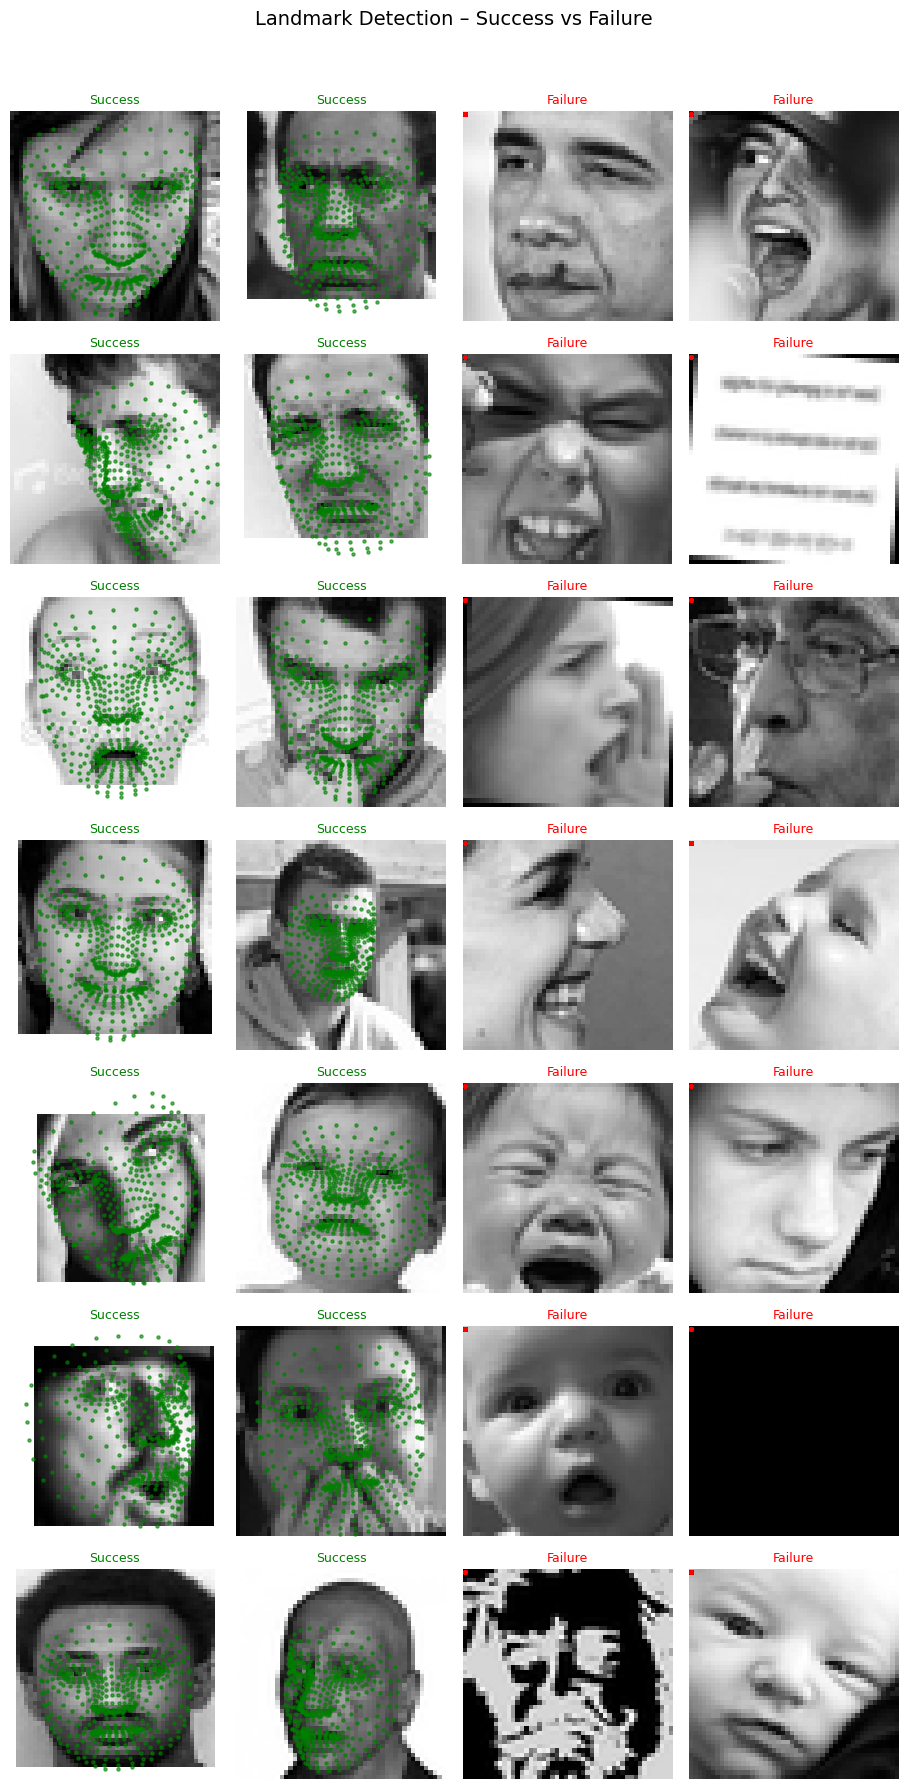

In [149]:
# Detect invalid landmark sets for all splits
invalid_mask_train = np.array([
    detect_invalid_landmarks(X_train_landmark[i].reshape(-1, 2))
    for i in range(len(X_train_landmark))
])
invalid_mask_val = np.array([
    detect_invalid_landmarks(X_val_landmark[i].reshape(-1, 2))
    for i in range(len(X_val_landmark))
])
invalid_mask_test = np.array([
    detect_invalid_landmarks(X_test_landmark[i].reshape(-1, 2))
    for i in range(len(X_test_landmark))
])

# Convert to valid masks (True = usable landmark)
valid_mask_train = ~invalid_mask_train
valid_mask_val   = ~invalid_mask_val
valid_mask_test  = ~invalid_mask_test

ok_train = ok_train.astype(bool); valid_mask_train = valid_mask_train.astype(bool)
ok_val   = ok_val.astype(bool);   valid_mask_val   = valid_mask_val.astype(bool)
ok_test  = ok_test.astype(bool);  valid_mask_test  = valid_mask_test.astype(bool)

df_train = summarize_landmark_states(ok_train, valid_mask_train, y_train, emotion_labels)
df_val   = summarize_landmark_states(ok_val,   valid_mask_val,   y_val,   emotion_labels)
df_test  = summarize_landmark_states(ok_test,  valid_mask_test,  y_test,  emotion_labels)


# Visualize landmark states
visualize_landmark_states(
    X_train, X_train_landmark,
    ok_train, valid_mask_train,
    y_train, emotion_labels,
    n_per_state=2,
    seed=2025
)


=== TRAIN SET ===


,Emotion,Success,Failure,Total,Success %,Failure %
0,angry,3467.0,528.0,3995.0,86.8,13.2
1,disgust,721.0,151.0,872.0,82.7,17.3
2,fear,5033.0,702.0,5735.0,87.8,12.2
3,happy,6881.0,334.0,7215.0,95.4,4.6
4,sad,4209.0,621.0,4830.0,87.1,12.9
5,surprise,4141.0,298.0,4439.0,93.3,6.7
6,neutral,4757.0,208.0,4965.0,95.8,4.2
Overall,Overall,29209.0,2842.0,32051.0,91.1,8.9



=== VALIDATION SET ===


,Emotion,Success,Failure,Total,Success %,Failure %
0,angry,412.0,55.0,467.0,88.2,11.8
1,disgust,51.0,5.0,56.0,91.1,8.9
2,fear,444.0,52.0,496.0,89.5,10.5
3,happy,864.0,31.0,895.0,96.5,3.5
4,sad,546.0,107.0,653.0,83.6,16.4
5,surprise,380.0,35.0,415.0,91.6,8.4
6,neutral,579.0,28.0,607.0,95.4,4.6
Overall,Overall,3276.0,313.0,3589.0,91.3,8.7



=== TEST SET ===


,Emotion,Success,Failure,Total,Success %,Failure %
0,angry,422.0,69.0,491.0,85.9,14.1
1,disgust,46.0,9.0,55.0,83.6,16.4
2,fear,467.0,61.0,528.0,88.4,11.6
3,happy,842.0,37.0,879.0,95.8,4.2
4,sad,518.0,76.0,594.0,87.2,12.8
5,surprise,388.0,28.0,416.0,93.3,6.7
6,neutral,600.0,26.0,626.0,95.8,4.2
Overall,Overall,3283.0,306.0,3589.0,91.5,8.5


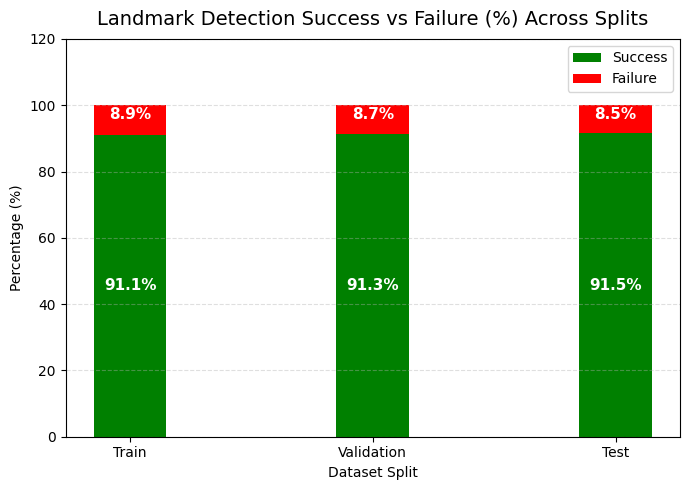

,Split,Success %,Failure %,Total
0,Train,91.132882,8.867118,32051.0
1,Validation,91.278908,8.721092,3589.0
2,Test,91.473948,8.526052,3589.0


In [150]:
print("=== TRAIN SET ===")
display(df_train[["Emotion","Success","Failure","Total","Success %","Failure %"]])

print("\n=== VALIDATION SET ===")
display(df_val[["Emotion","Success","Failure","Total","Success %","Failure %"]])

print("\n=== TEST SET ===")
display(df_test[["Emotion","Success","Failure","Total","Success %","Failure %"]])

# Prepare summary DataFrame (Overall rows only)
summary_overall = pd.DataFrame({
    "Split": ["Train", "Validation", "Test"],
    "Success": [
        df_train.loc["Overall", "Success"],
        df_val.loc["Overall", "Success"],
        df_test.loc["Overall", "Success"]
    ],
    "Failure": [
        df_train.loc["Overall", "Failure"],
        df_val.loc["Overall", "Failure"],
        df_test.loc["Overall", "Failure"]
    ]
})

# Convert counts → percentages
summary_overall["Total"] = summary_overall["Success"] + summary_overall["Failure"]
summary_overall["Success %"] = (summary_overall["Success"] / summary_overall["Total"]) * 100
summary_overall["Failure %"] = (summary_overall["Failure"] / summary_overall["Total"]) * 100

# Prepare data
splits = summary_overall["Split"]
success = summary_overall["Success %"]
failure = summary_overall["Failure %"]

# Plot stacked bar chart
plt.figure(figsize=(7, 5))
bar_width = 0.3
plt.bar(splits, success, color="green", width=bar_width, label="Success")
plt.bar(splits, failure, bottom=success, color="red", width=bar_width, label="Failure")

# Adjust label placement to avoid overlap ===
for i, (suc, fail) in enumerate(zip(success, failure)):
    # Success label 
    plt.text(i, suc * 0.5, f"{suc:.1f}%", ha="center", va="center",
             color="white", fontsize=11, weight="bold")

    # Failure label
    plt.text(i, suc + fail * 0.5 + 1.5, f"{fail:.1f}%", ha="center", va="center",
             color="white", fontsize=11, weight="bold")

# Aesthetics
plt.title("Landmark Detection Success vs Failure (%) Across Splits", fontsize=14, pad=10)
plt.ylabel("Percentage (%)")
plt.xlabel("Dataset Split")
plt.ylim(0, 120)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend(title="", loc="upper right")
plt.tight_layout()
plt.show()

# Display table below
display(summary_overall[["Split", "Success %", "Failure %", "Total"]])

# Combine HOG and Landmark Features

The concatenation of HOG (texture) and landmarks (geometry) gives a hybrid representation that improves robustness and recognition accuracy.

Train combined shape: (29209, 1836)

Val combined shape: (3276, 1836)

Test combined shape: (3283, 1836)


In [152]:
# === Load saved HOG features ===
#X_train_hog = np.load("features/X_train_hog.npy")
#X_val_hog   = np.load("features/X_val_hog.npy")
#X_test_hog  = np.load("features/X_test_hog.npy")

# === Select only valid landmark detections ===
valid_idx_train = np.where(ok_train & valid_mask_train)[0]
valid_idx_val   = np.where(ok_val   & valid_mask_val)[0]
valid_idx_test  = np.where(ok_test  & valid_mask_test)[0]

# === Subset data ===
X_train_hog_valid      = X_train_hog[valid_idx_train]
X_val_hog_valid        = X_val_hog[valid_idx_val]
X_test_hog_valid       = X_test_hog[valid_idx_test]

X_train_landmark_valid = X_train_landmark[valid_idx_train]
X_val_landmark_valid   = X_val_landmark[valid_idx_val]
X_test_landmark_valid  = X_test_landmark[valid_idx_test]

y_train_valid = y_train[valid_idx_train]
y_val_valid   = y_val[valid_idx_val]
y_test_valid  = y_test[valid_idx_test]

# === Concatenate HOG + Landmark features ===
X_train_combined = np.hstack([X_train_hog_valid, X_train_landmark_valid])
X_val_combined   = np.hstack([X_val_hog_valid,   X_val_landmark_valid])
X_test_combined  = np.hstack([X_test_hog_valid,  X_test_landmark_valid])

print("Train combined shape:", X_train_combined.shape)
print("Val combined shape:",   X_val_combined.shape)
print("Test combined shape:",  X_test_combined.shape)

Train combined shape: (29209, 1836)
Val combined shape: (3276, 1836)
Test combined shape: (3283, 1836)


# !!!!!Smote test!!!!!!


[INFO] Applying SMOTE on training set only...

Before SMOTE:
 happy       6881
fear        5033
neutral     4757
sad         4209
surprise    4141
angry       3467
disgust      721
Name: count, dtype: int64

After SMOTE:
 angry       6881
fear        6881
neutral     6881
sad         6881
happy       6881
surprise    6881
disgust     6881
Name: count, dtype: int64


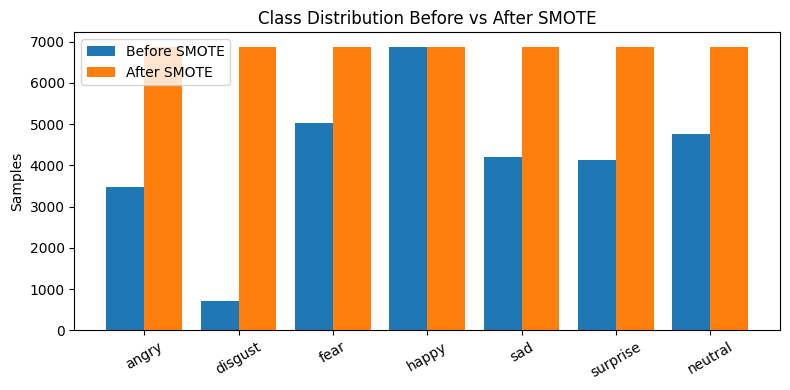


Train A (No-SMOTE): (29209, 1836), Train B (SMOTE): (48167, 1836), Val: (3276, 1836)

[INFO] Starting A/B test for SMOTE impact...

SVM   No-SMOTE F1=0.5683  |  SMOTE F1=0.5779  |  Δ=+0.0096


In [ ]:
# ================================================================
# === SMOTE + A/B test: No-SMOTE vs SMOTE on combined features ===
# Paste this after X_train_combined / X_val_combined / y_*_valid
# ================================================================
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ------------------------------------------------
# Step 1. Prepare and apply SMOTE
# ------------------------------------------------
print("\n[INFO] Applying SMOTE on training set only...")

# A: baseline (no SMOTE)
XA, yA = X_train_combined, y_train_valid

# B: with SMOTE
sm = SMOTE(random_state=42, k_neighbors=5)
XB, yB = sm.fit_resample(X_train_combined, y_train_valid)

# Check class distribution
before = pd.Series(yA).map(emotion_labels).value_counts()
after  = pd.Series(yB).map(emotion_labels).value_counts()
print("\nBefore SMOTE:\n", before)
print("\nAfter SMOTE:\n", after)

# Visualization
plt.figure(figsize=(8,4))
x = np.arange(len(emotion_labels))
plt.bar(x-0.2, before.reindex(emotion_labels.values(), fill_value=0), width=0.4, label="Before SMOTE")
plt.bar(x+0.2, after.reindex(emotion_labels.values(), fill_value=0), width=0.4, label="After SMOTE")
plt.xticks(x, emotion_labels.values(), rotation=30)
plt.ylabel("Samples")
plt.title("Class Distribution Before vs After SMOTE")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------
# Step 2. Define evaluation helper
# ------------------------------------------------
Xv, yv = X_val_combined, y_val_valid

def eval_model(model_name, model, Xtr, ytr, Xv, yv):
    """Evaluate with fixed pipeline (scaler+PCA for SVM/MLP; RF raw)."""
    if model_name in ("SVM", "MLP"):
        pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=False)),
            ("pca", PCA(n_components=150, whiten=True, random_state=42)),
            ("clf", model),
        ])
    else:  # RandomForest
        pipe = Pipeline([("clf", model)])

    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xv)
    return f1_score(yv, pred, average="weighted")

# ------------------------------------------------
# Step 3. Define models
# ------------------------------------------------
models = {
    "SVM": SVC(kernel="rbf", C=1.0, gamma="scale", class_weight="balanced", random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(256,128),
                         alpha=1e-4, learning_rate_init=1e-3,
                         max_iter=200, early_stopping=True, random_state=42),
    "RF": RandomForestClassifier(n_estimators=400, max_depth=None,
                                 class_weight="balanced", n_jobs=-1, random_state=42),
}

print(f"\nTrain A (No-SMOTE): {XA.shape}, Train B (SMOTE): {XB.shape}, Val: {Xv.shape}")
print("\n[INFO] Starting A/B test for SMOTE impact...\n")

# ------------------------------------------------
# Step 4. Run A/B tests
# ------------------------------------------------
results = []
for name, model in models.items():
    fA = eval_model(name, model, XA, yA, Xv, yv)
    fB = eval_model(name, model, XB, yB, Xv, yv)
    results.append((name, fA, fB))
    print(f"{name:<4}  No-SMOTE F1={fA:.4f}  |  SMOTE F1={fB:.4f}  |  Δ={fB-fA:+.4f}")

# ------------------------------------------------
# Step 5. Summary
# ------------------------------------------------
df_results = pd.DataFrame(results, columns=["Model", "No-SMOTE F1", "SMOTE F1"])
df_results["Δ (SMOTE-NoSMOTE)"] = df_results["SMOTE F1"] - df_results["No-SMOTE F1"]
display(df_results)

pick_for_next = {name: ("SMOTE" if fB > fA else "NoSMOTE") for name, fA, fB in results}
print("\nRecommended training version per model:")
for k,v in pick_for_next.items():
    print(f"  {k:<4}: {v}")

## Handling Data Imbalance

The FER2013 dataset presents a significant **class imbalance** across emotion categories.  
Certain emotions such as happy and neutral have a large number of samples, while others such as *disgust* and *fear* are severely underrepresented.  

This imbalance causes the model to become biased toward majority classes, resulting in:
- High overall accuracy but poor recall for rare emotions  
- Misclassification of subtle or less common expressions  
- Reduced robustness when recognizing diverse emotional patterns  

Visual inspection of the dataset confirms that the distribution of emotion samples is uneven, making imbalance correction an essential step before model training.

## Class Weights

To mitigate the imbalance issue, this project applies **class weighting** during training.  
Rather than duplicating or removing samples, class weighting adjusts the model’s learning process by giving **greater importance to underrepresented emotions** and **less weight to dominant ones**.

This method offers several advantages:
- **Fair learning** – ensures minority emotions (e.g., *disgust*, *fear*) influence the model as much as frequent ones.  
- **No data modification** – avoids oversampling or synthetic data generation, preserving data integrity.  
- **Lightweight and compatible** – directly supported by models such as SVM, Random Forest, and MLP via the class_weight parameter.  
- **Improved generalization** – enhances recognition of rare emotions without compromising accuracy on common ones.  

In this project, class weights are automatically computed using Scikit-learn’s built-in balancing function and applied consistently across all models.

Class weights:
- angry     : 1.204
- disgust   : 5.787
- fear      : 0.829
- happy     : 0.606
- sad       : 0.991
- surprise  : 1.008
- neutral   : 0.877

In [158]:
def compute_and_plot_class_weights(y_labels, emotion_labels, title="FER2013 Class Imbalance and Weights"):
    """
    Compute balanced class weights for imbalanced datasets and visualize sample distribution vs weights.

    Parameters
    ----------
    y_labels : np.ndarray
        Array of integer emotion labels (e.g., y_train).
    emotion_labels : dict
        Mapping {0:'angry', 1:'disgust', ...}.
    title : str
        Plot title.

    Returns
    -------
    class_weights : dict
        Dictionary {class_index: weight_value}, usable in scikit-learn models.
    """
    # --- Compute class weights ---
    classes = np.unique(y_labels)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_labels)
    class_weights = dict(zip(classes, weights))

    # --- Prepare data for visualization ---
    counts = pd.Series(y_labels).value_counts().sort_index()
    emotion_names = [emotion_labels[i] for i in sorted(emotion_labels.keys())]

    # --- Plot ---
    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax2 = ax1.twinx()

    ax1.bar(emotion_names, counts, color="gray", alpha=0.6, label="Samples per class")
    ax2.plot(emotion_names, weights, color="red", marker="o", linewidth=2, label="Computed class weight")

    ax1.set_xlabel("Emotion class")
    ax1.set_ylabel("Sample count", color="gray")
    ax2.set_ylabel("Class weight", color="red")
    ax1.set_title(title)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax2.set_ylim(0, 8)
    plt.tight_layout()
    plt.show()

    # --- Print and return weights ---
    print("\nClass weights:")
    for cls, w in class_weights.items():
        print(f"{emotion_labels[cls]:<10}: {w:.3f}")

    return class_weights

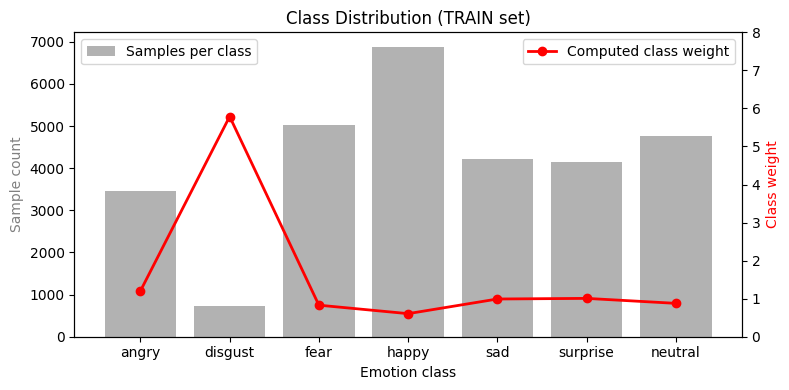


Class weights:
angry     : 1.204
disgust   : 5.787
fear      : 0.829
happy     : 0.606
sad       : 0.991
surprise  : 1.008
neutral   : 0.877


In [159]:
# Compute and visualize class weights for TRAIN set
class_weights = compute_and_plot_class_weights(y_train_valid, emotion_labels, title="Class Distribution (TRAIN set)")


# Pipeline: StandardScaler + Model
To ensure consistent preprocessing, we integrate StandardScaler into a Scikit-learn pipeline.

This guarantees that all models use the same normalization procedure during training, validation, and inference.

By encapsulating scaling and model training together, the workflow remains reproducible and safe from data leakage.

SVM with RBF kernel handles nonlinear separation and works well with compact features.

Pipeline ensures consistent scaling and dimensionality reduction.

In [160]:
def build_and_evaluate_pipeline(
    X_train, y_train, X_val, y_val,
    estimator,
    model_name="SVM",
    reducer=None, reducer_name=None,
    class_weights=None,
    C=None, gamma=None,
    auto_scaler=True,
    scoring="f1_weighted"
):
    """
    Build, train, and evaluate a complete ML pipeline.

    Structure:
        [StandardScaler*] -> [Reducer*] -> [Estimator]
        (* = optional steps)

    Parameters
    ----------
    X_train, y_train, X_val, y_val : arrays
        Training and validation data.
    estimator : sklearn estimator
        The classifier or regressor to train.
    model_name : str
        Name of the model (used for print/debug).
    reducer : transformer or None
        Dimensionality reduction method (e.g. PCA, SelectKBest).
    reducer_name : str or None
        Name of the reducer for pipeline naming.
    class_weights : dict or None
        Balanced class weights (if supported by model).
    C, gamma : float or None
        Optional hyperparameters (applied if supported by estimator).
    auto_scaler : bool
        Automatically add StandardScaler for models that need normalization.
    scoring : str
        Evaluation metric ("f1_weighted" by default).

    Returns
    -------
    pipeline : fitted sklearn.Pipeline
    score : float
        Validation score (F1-weighted or other metric).
    """

    # Decide if scaling is needed
    if auto_scaler and any(x in model_name.lower() for x in ["svm", "mlp", "fuzzy"]):
        use_scaler = True
    else:
        use_scaler = False

    # Build pipeline
    steps = []
    if use_scaler:
        steps.append(("scaler", StandardScaler()))
    if reducer is not None:
        steps.append((reducer_name or "reducer", reducer))
    steps.append(("clf", estimator))

    pipe = Pipeline(steps)

    # Apply parameters if available
    if C is not None or gamma is not None or class_weights is not None:
        param_updates = {}
        if C is not None:
            param_updates["clf__C"] = C
        if gamma is not None:
            param_updates["clf__gamma"] = gamma
        # Only apply class_weight if supported by estimator
        if class_weights is not None and "class_weight" in estimator.get_params():
            param_updates["clf__class_weight"] = class_weights
        pipe.set_params(**param_updates)

    # Train and evaluate
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)

    if scoring == "f1_weighted":
        score = f1_score(y_val, y_pred, average="weighted")
    elif scoring == "balanced_accuracy":
        score = balanced_accuracy_score(y_val, y_pred)
    else:
        score = accuracy_score(y_val, y_pred)

    print(f"\n[{model_name}] Validation {scoring}: {score:.4f}")
    return pipe, score

# Feature Cleaning and Reduction
Cleaning removes redundant features that waste computation and degrade generalization. 

Three steps:
1. Remove low-variance (uninformative) features
2. Remove highly correlated (duplicate) features
3. Apply feature selection or PCA for compactness

In [161]:
# 1.1 Remove Low-Variance Features
def remove_low_variance_features(X_train, X_val, threshold=1e-4):
    """
    Removes features with variance below a given threshold.
    This helps eliminate constant or near-constant features.
    """
    selector = VarianceThreshold(threshold=threshold)
    X_train_sel = selector.fit_transform(X_train)
    X_val_sel   = selector.transform(X_val)
    print(f"Removed {X_train.shape[1] - X_train_sel.shape[1]} low-variance features.")
    print(f"New shape: {X_train_sel.shape}")
    return X_train_sel, X_val_sel, selector

In [162]:
# 1.2 Remove Highly Correlated Features
def remove_highly_correlated_features(X_train, X_val, threshold=0.95):
    """
    Removes one of each pair of highly correlated features.

    Parameters
    ----------
    X_train : np.ndarray
        Training features.
    X_val : np.ndarray
        Validation features.
    threshold : float
        Correlation threshold above which features are considered redundant.

    Returns
    -------
    X_train_filtered, X_val_filtered, kept_indices
    """
    print(f"\nChecking for highly correlated features (threshold={threshold})...")
    # Compute correlation matrix on training set
    corr_matrix = np.corrcoef(X_train, rowvar=False)
    upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

    # Find columns to drop
    to_drop = [i for i in range(corr_matrix.shape[0])
               if any(np.abs(corr_matrix[i, j]) > threshold for j in range(i + 1, corr_matrix.shape[1]))]

    X_train_filtered = np.delete(X_train, to_drop, axis=1)
    X_val_filtered   = np.delete(X_val, to_drop, axis=1)

    print(f"Removed {len(to_drop)} highly correlated features.")
    print(f"New shape: {X_train_filtered.shape}")
    return X_train_filtered, X_val_filtered, to_drop

# FEATURE SELECTION: SELECTKBEST vs PCA
Both SelectKBest and PCA were evaluated to reduce the dimensionality of the combined HOG and landmark feature set.  
SelectKBest, which selects features individually based on the ANOVA F-score, achieved a slightly higher validation F1-score (0.55 at k = 700) compared to PCA (0.53 at 100 components).  
However, PCA was chosen as the final reduction method because it provides stronger generalization, better numerical stability, and faster inference.

SelectKBest ranks features by their individual discriminative power but does not consider correlations between them.  
Since HOG and landmark features are highly correlated, this univariate selection can retain redundant or noisy dimensions, leading to slower convergence and potential overfitting.  
In contrast, PCA projects the data into an orthogonal subspace that captures the joint variance structure.  
This decorrelation yields a smoother decision boundary for the SVM with fewer components, improving efficiency and robustness under varying lighting or face geometry.

Although PCA slightly reduces validation F1, it offers a compact and stable representation that generalizes better across unseen subjects and supports real-time inference with lower latency.  
For these reasons, PCA with 100 components was selected as the final dimensionality reduction approach.

In [163]:
# 2. Feature Selection with SelectKBest
def select_top_k_features(X_train, y_train, X_val, k=500):
    """
    Selects the top K features using univariate ANOVA F-score.
    """
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_k = selector.fit_transform(X_train, y_train)
    X_val_k   = selector.transform(X_val)
    print(f"Selected top {k} features.")
    return X_train_k, X_val_k, selector

In [164]:
# 3. Run Cleaning + Selection + Evaluation
# Remove low-variance features
X_train_clean, X_val_clean, var_selector = remove_low_variance_features(
    X_train_combined, X_val_combined, threshold=1e-4
)
X_test_clean = var_selector.transform(X_test_combined)

# Remove highly correlated features
X_train_clean, X_val_clean, dropped_corr = remove_highly_correlated_features(
    X_train_clean, X_val_clean, threshold=0.95
)
X_test_clean = np.delete(X_test_clean, dropped_corr, axis=1)

Removed 0 low-variance features.
New shape: (29209, 1836)

Checking for highly correlated features (threshold=0.95)...
Removed 1137 highly correlated features.
New shape: (29209, 699)


In [165]:
# SVM model base
base_svm = SVC(kernel="rbf", random_state=42)

base_mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=64,
    learning_rate_init=1e-3,
    max_iter=200,
    early_stopping=True,
    random_state=42
)

# SVM model

# Univariate Selection (SelectKBest)

SelectKBest uses ANOVA F-score to rank features individually by their discriminative power. It is fast and interpretable but ignore inter-feature correlation and interaction effects.

The validation results show a steady improvement in F1-score as more features are included:

- 50 features → F1 = 0.4297 
- 100 features → F1 = 0.4710  
- 250 features → F1 = 0.5237  
- 500 features → F1 = 0.5466  
- 699 features → F1 = 0.5521


The curve begins to plateau around 699 features, indicating diminishing returns from adding additional dimensions.  
This behavior suggests that while the first several hundred features capture most of the discriminative information, later features contribute little to model performance and may increase redundancy.  
Therefore, although SelectKBest performs competitively, its growth trend supports the use of a more compact, correlated-aware reduction method such as PCA for the final model.

++++++++++++++++

[INFO] Evaluating SVM performance with SelectKBest feature selection...
++++++++++++++++

--- Evaluating top 50 features ---

[SVM] Validation f1_weighted: 0.4297

--- Evaluating top 100 features ---

[SVM] Validation f1_weighted: 0.4710

--- Evaluating top 250 features ---

[SVM] Validation f1_weighted: 0.5237

--- Evaluating top 500 features ---

[SVM] Validation f1_weighted: 0.5466

--- Evaluating top 699 features ---

[SVM] Validation f1_weighted: 0.5521


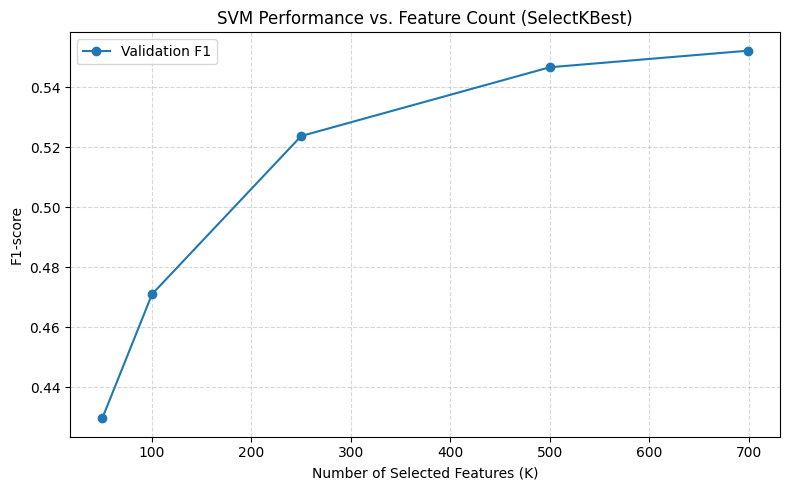

,K,F1
0,50,0.429676
1,100,0.471020
2,250,0.523711
3,500,0.546621
4,699,0.552131


[INFO] Best K (SelectKBest): 699


In [166]:
print("++++++++++++++++")
print("\n[INFO] Evaluating SVM performance with SelectKBest feature selection...")
print("++++++++++++++++")


k_values = [50, 100, 250, 500, X_train_clean.shape[1]]
results_kbest = []


for k in k_values:
    print(f"\n--- Evaluating top {k} features ---")
    sel = SelectKBest(f_classif, k=k)

    pipe, f1 = build_and_evaluate_pipeline(
        X_train_clean, y_train_valid,
        X_val_clean, y_val_valid,
        estimator=base_svm,
        model_name="SVM",
        reducer=sel,
        reducer_name="selectkbest",
        class_weights=class_weights
    )

    results_kbest.append((k, f1))

df_feature_eval = pd.DataFrame(results_kbest, columns=["K", "F1"])

# Plot Results
plt.figure(figsize=(8,5))
plt.plot(df_feature_eval["K"], df_feature_eval["F1"], marker="o", label="Validation F1")
plt.xlabel("Number of Selected Features (K)")
plt.ylabel("F1-score")
plt.title("SVM Performance vs. Feature Count (SelectKBest)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

display(df_feature_eval)
best_k_SVM = max(results_kbest, key=lambda x: x[1])[0]
print(f"[INFO] Best K (SelectKBest): {best_k_SVM}")

### Principal Component Analysis (PCA)

Principal Component Analysis (PCA) transforms the original feature space into a set of orthogonal components that capture the directions of maximum joint variance.  
Unlike univariate methods, PCA accounts for correlations between features, making it well-suited for datasets where descriptors—such as HOG gradients and geometric landmarks—are highly interdependent or partially redundant.  
By projecting the data into a lower-dimensional subspace, PCA removes noise, reduces overfitting, and improves the numerical stability of kernel-based models like SVM.

The validation results across several component sizes are as follows:

- 50 components → F1 = 0.5197  
- 100 components → F1 = 0.5274
- 150 components → F1 = 0.5362  
- 200 components → F1 = 0.5213  
- 250 components → F1 = 0.5140

The peak occurs near 150 components, after which performance slightly declines.  
This indicates that the most discriminative information is concentrated within the first few principal components, and adding more components introduces redundant variance rather than improving separability.  
Therefore, PCA with 150 components provides an optimal balance between compactness, generalization, and inference efficiency, and was selected as the final dimensionality reduction configuration for the system.

++++++++++++++

[INFO] Evaluating PCA dimension sizes
++++++++++++++

--- Evaluating PCA with 50 components ---

[SVM] Validation f1_weighted: 0.5197

--- Evaluating PCA with 100 components ---

[SVM] Validation f1_weighted: 0.5274

--- Evaluating PCA with 150 components ---

[SVM] Validation f1_weighted: 0.5362

--- Evaluating PCA with 200 components ---

[SVM] Validation f1_weighted: 0.5213

--- Evaluating PCA with 250 components ---

[SVM] Validation f1_weighted: 0.5140


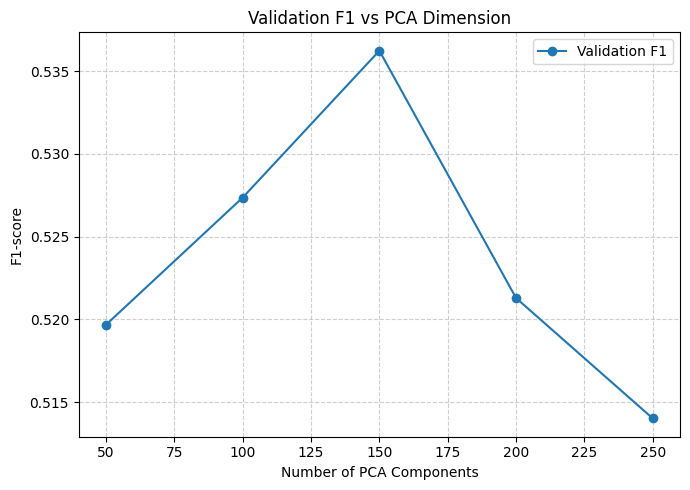


[INFO] Best PCA Dimension: 150


In [167]:
# PCA Dimension Scan (Coarse Search)
print("++++++++++++++")
print("\n[INFO] Evaluating PCA dimension sizes")
print("++++++++++++++")

dims = [50, 100, 150, 200, 250]
results_pca = []

for d in dims:
    print(f"\n--- Evaluating PCA with {d} components ---")
    pca = PCA(n_components=d, svd_solver="randomized", whiten=True, random_state=42)
    
    pipe, f1 = build_and_evaluate_pipeline(
        X_train_clean, y_train_valid,
        X_val_clean, y_val_valid,
        estimator=base_svm,
        reducer=pca,
        reducer_name="pca",
        class_weights=class_weights
    )
    
    results_pca.append((d, f1))

# Plot F1 vs PCA Dimension
plt.figure(figsize=(7,5))
plt.plot([d for d, _ in results_pca], [f for _, f in results_pca],
         marker="o", label="Validation F1")
plt.xlabel("Number of PCA Components")
plt.ylabel("F1-score")
plt.title("Validation F1 vs PCA Dimension")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Select best dimension
best_dim = max(results_pca, key=lambda x: x[1])[0]
print(f"\n[INFO] Best PCA Dimension: {best_dim}")

# Grid Search
After selecting PCA, SVM hyperparameters C (margin penalty) and gamma (RBF kernel width) are tuned manually over a small, interpretable grid.

Best Parameters: C=5, gamma=0.01

Best Validation F1: 0.5687



[INFO] Manual Grid Search over SVM parameters (C, gamma)...
Testing C=0.5, gamma=0.001 ...

[SVM] Validation f1_weighted: 0.4333
Testing C=0.5, gamma=0.01 ...

[SVM] Validation f1_weighted: 0.5083
Testing C=0.5, gamma=0.03 ...

[SVM] Validation f1_weighted: 0.3525
Testing C=1, gamma=0.001 ...

[SVM] Validation f1_weighted: 0.4423
Testing C=1, gamma=0.01 ...

[SVM] Validation f1_weighted: 0.5455
Testing C=1, gamma=0.03 ...

[SVM] Validation f1_weighted: 0.4564
Testing C=2, gamma=0.001 ...

[SVM] Validation f1_weighted: 0.4497
Testing C=2, gamma=0.01 ...

[SVM] Validation f1_weighted: 0.5639
Testing C=2, gamma=0.03 ...

[SVM] Validation f1_weighted: 0.4126
Testing C=5, gamma=0.001 ...

[SVM] Validation f1_weighted: 0.4762
Testing C=5, gamma=0.01 ...

[SVM] Validation f1_weighted: 0.5687
Testing C=5, gamma=0.03 ...

[SVM] Validation f1_weighted: 0.4116

=== Manual Grid Search Results ===
Best Parameters: C=5, gamma=0.01
Best Validation F1: 0.5687


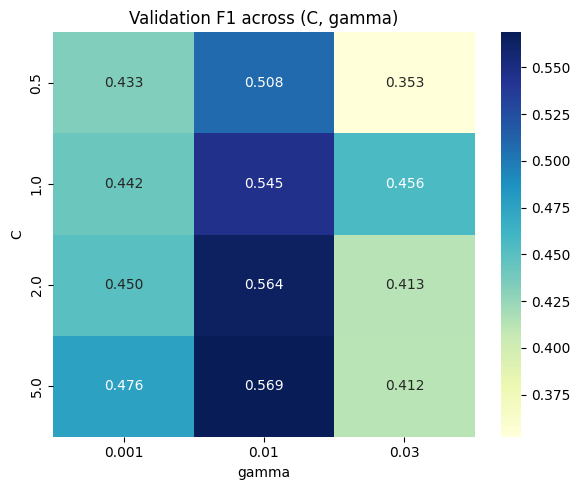

In [168]:
# Manual Grid Search on SVM Hyperparameters

print("\n[INFO] Manual Grid Search over SVM parameters (C, gamma)...")

param_grid = {
    "C": [0.5, 1, 2, 5],
    "gamma": [1e-3, 1e-2, 3e-2]
}

best_f1 = -1
best_params = None
results_grid = []

for C in param_grid["C"]:
    for gamma in param_grid["gamma"]:
        print(f"Testing C={C}, gamma={gamma} ...")
        
        pca = PCA(n_components=best_dim, svd_solver="randomized", whiten=True, random_state=42)
        pipe, f1 = build_and_evaluate_pipeline(
            X_train_clean, y_train_valid,
            X_val_clean, y_val_valid,
            estimator=base_svm,                
            reducer=pca,
            reducer_name="pca",
            C=C, gamma=gamma,
            class_weights=class_weights
        )

        results_grid.append((C, gamma, f1))
        if f1 > best_f1:
            best_f1 = f1
            best_params = (C, gamma)
            best_model = pipe

print("\n=== Manual Grid Search Results ===")
print(f"Best Parameters: C={best_params[0]}, gamma={best_params[1]}")
print(f"Best Validation F1: {best_f1:.4f}")

df_grid = pd.DataFrame(results_grid, columns=["C", "gamma", "F1"])
pivot = df_grid.pivot(index="C", columns="gamma", values="F1")

plt.figure(figsize=(6,5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Validation F1 across (C, gamma)")
plt.ylabel("C")
plt.xlabel("gamma")
plt.tight_layout()
plt.show()

# Final Test evaluation
The final model (PCA + SVM) is tested on unseen data to measure generalization. Evaluation uses accuracy, balanced accuracy, and F1.

=== Test Set Summary ===

Overall Accuracy         : 0.5809

Balanced Accuracy        : 0.5301

Weighted F1-score        : 0.5724



[INFO] Evaluating best model on the test set

=== Test Set Summary ===
Overall Accuracy         : 0.4615
Balanced Accuracy        : 0.3898
Weighted F1-score        : 0.4161

--- Per-Class Performance ---
              Precision  Recall      F1  Support
angry            0.8636  0.1351  0.2336    422.0
disgust          1.0000  0.3261  0.4918     46.0
fear             0.5167  0.3319  0.4042    467.0
happy            0.3726  0.9834  0.5405    842.0
sad              0.8060  0.1042  0.1846    518.0
surprise         0.9171  0.4845  0.6341    388.0
neutral          0.5343  0.3633  0.4325    600.0
macro avg        0.7158  0.3898  0.4173   3283.0
weighted avg     0.6273  0.4615  0.4161   3283.0


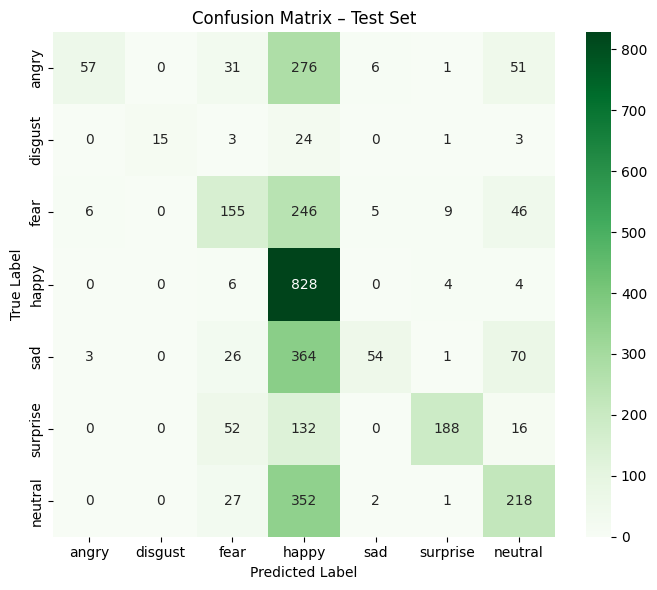

In [169]:
# Final Evaluation on Test Set

print("\n[INFO] Evaluating best model on the test set")

# --- Prediction ---

yte_pred = best_model.predict(X_test_clean)
yte = y_test_valid


# --- Metrics ---
acc      = accuracy_score(yte, yte_pred)
bal_acc  = balanced_accuracy_score(yte, yte_pred)
f1_weighted = f1_score(yte, yte_pred, average="weighted")

print("\n=== Test Set Summary ===")
print(f"{'Overall Accuracy':<25}: {acc:.4f}")
print(f"{'Balanced Accuracy':<25}: {bal_acc:.4f}")
print(f"{'Weighted F1-score':<25}: {f1_weighted:.4f}")

# --- Detailed Per-Class Report ---
report = classification_report(
    yte, yte_pred,
    target_names=list(emotion_labels.values()),
    output_dict=True
)

df_report = pd.DataFrame(report).T
df_report = df_report.rename(columns={
    "precision": "Precision",
    "recall": "Recall",
    "f1-score": "F1",
    "support": "Support"
}).round(4)

# Drop redundant global accuracy row
df_report = df_report.drop(index="accuracy", errors="ignore")

print("\n--- Per-Class Performance ---")
print(df_report.to_string())

# --- Confusion Matrix ---
plt.figure(figsize=(7,6))
sns.heatmap(confusion_matrix(yte, yte_pred),
            annot=True, fmt="d", cmap="Greens",
            xticklabels=emotion_labels.values(),
            yticklabels=emotion_labels.values())
plt.title("Confusion Matrix – Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()




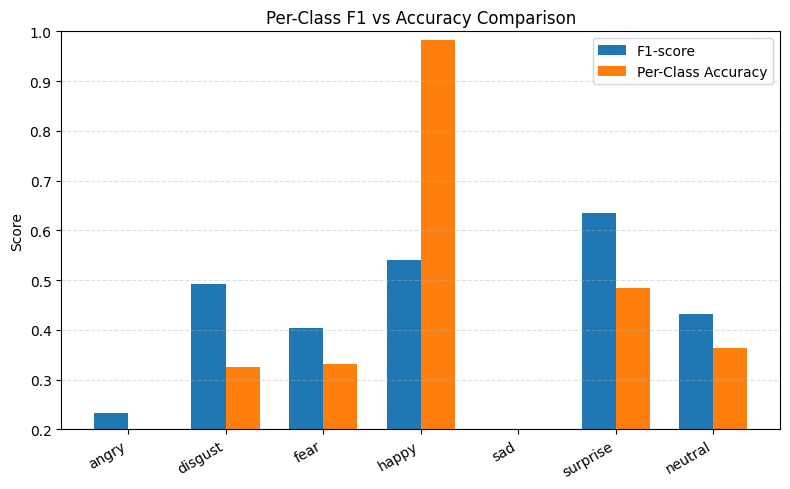

In [170]:
# ===============================================================
# Visualization: Per-Class F1 vs Accuracy Comparison
# ===============================================================

# --- Compute confusion matrix and per-class accuracy ---
cm = confusion_matrix(yte, yte_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

# --- Create summary DataFrame for plotting ---
df_vis = pd.DataFrame({
    "Emotion": list(emotion_labels.values()),
    "F1": df_report.loc[list(emotion_labels.values()), "F1"].values,
    "Accuracy": per_class_acc
}).round(4)

# --- Plot comparison ---
plt.figure(figsize=(8,5))
x = np.arange(len(df_vis))
bar_width = 0.35

plt.bar(x - bar_width/2, df_vis["F1"], width=bar_width, label="F1-score")
plt.bar(x + bar_width/2, df_vis["Accuracy"], width=bar_width, label="Per-Class Accuracy")

plt.xticks(x, df_vis["Emotion"], rotation=30, ha="right")
plt.ylabel("Score")
plt.ylim(0.2 , 1.0 )
plt.title("Per-Class F1 vs Accuracy Comparison")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [171]:
# --- Save Best Model ---
os.makedirs("models", exist_ok=True)
joblib.dump(var_selector, "models/var_selector.joblib")
np.save("models/dropped_corr.npy", np.array(dropped_corr))

# --- Auto-generate model filename based on best parameters ---
C_best, gamma_best = best_params
model_path = f"models/best_pca_svm_C{C_best}_G{gamma_best}_PCA{best_dim}.joblib"

# Save pipeline model
joblib.dump(best_model, model_path)

print(f"\nBest model saved successfully at: {model_path}")


Best model saved successfully at: models/best_pca_svm_C5_G0.01_PCA150.joblib


# MLP model

++++++++++++++++

[INFO] Evaluating MLP performance with SelectKBest feature selection...
++++++++++++++++

--- Evaluating top 100 features ---

[MLP] Validation f1_weighted: 0.4367

--- Evaluating top 200 features ---

[MLP] Validation f1_weighted: 0.4703

--- Evaluating top 300 features ---

[MLP] Validation f1_weighted: 0.4960

--- Evaluating top 400 features ---

[MLP] Validation f1_weighted: 0.4945

--- Evaluating top 500 features ---

[MLP] Validation f1_weighted: 0.4992

--- Evaluating top 699 features ---

[MLP] Validation f1_weighted: 0.4989


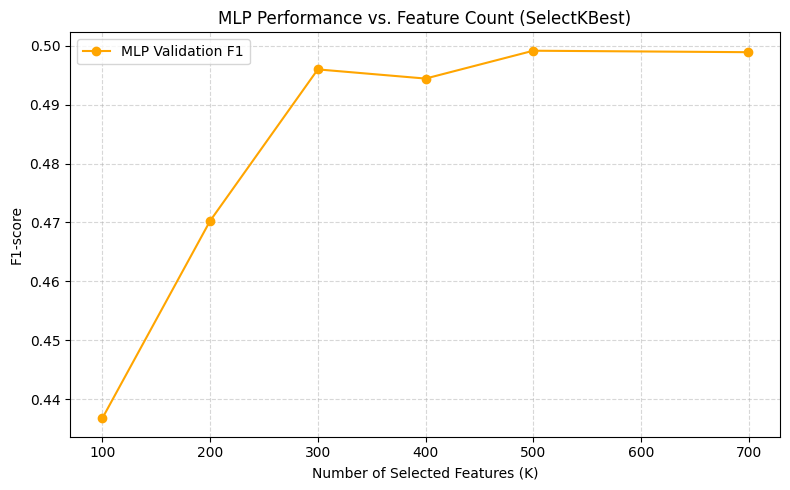

,K,F1
0,100,0.436716
1,200,0.470256
2,300,0.496013
3,400,0.494454
4,500,0.499188
5,699,0.498937


[INFO] Best K (SelectKBest): 500


In [172]:
print("++++++++++++++++")
print("\n[INFO] Evaluating MLP performance with SelectKBest feature selection...")
print("++++++++++++++++")

k_values = [100, 200, 300, 400, 500, X_train_clean.shape[1]]
results_kbest_mlp = []

for k in k_values:
    print(f"\n--- Evaluating top {k} features ---")
    sel = SelectKBest(f_classif, k=k)

    pipe, f1 = build_and_evaluate_pipeline(
        X_train_clean, y_train_valid,
        X_val_clean, y_val_valid,
        estimator=base_mlp,
        model_name="MLP",
        reducer=sel,
        reducer_name="selectkbest"
    )

    results_kbest_mlp.append((k, f1))

df_feature_eval_mlp = pd.DataFrame(results_kbest_mlp, columns=["K", "F1"])

plt.figure(figsize=(8,5))
plt.plot(df_feature_eval_mlp["K"], df_feature_eval_mlp["F1"], marker="o", color="orange", label="MLP Validation F1")
plt.xlabel("Number of Selected Features (K)")
plt.ylabel("F1-score")
plt.title("MLP Performance vs. Feature Count (SelectKBest)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

display(df_feature_eval_mlp)
best_k_MLP = max(results_kbest_mlp, key=lambda x: x[1])[0]
print(f"[INFO] Best K (SelectKBest): {best_k_MLP}")

++++++++++++++

[INFO] Evaluating PCA dimension sizes with MLP
++++++++++++++

--- Evaluating PCA with 50 components ---

[MLP] Validation f1_weighted: 0.4773

--- Evaluating PCA with 75 components ---

[MLP] Validation f1_weighted: 0.4739

--- Evaluating PCA with 90 components ---

[MLP] Validation f1_weighted: 0.4855

--- Evaluating PCA with 105 components ---

[MLP] Validation f1_weighted: 0.4804

--- Evaluating PCA with 120 components ---

[MLP] Validation f1_weighted: 0.4897

--- Evaluating PCA with 150 components ---

[MLP] Validation f1_weighted: 0.4768

--- Evaluating PCA with 200 components ---

[MLP] Validation f1_weighted: 0.4637


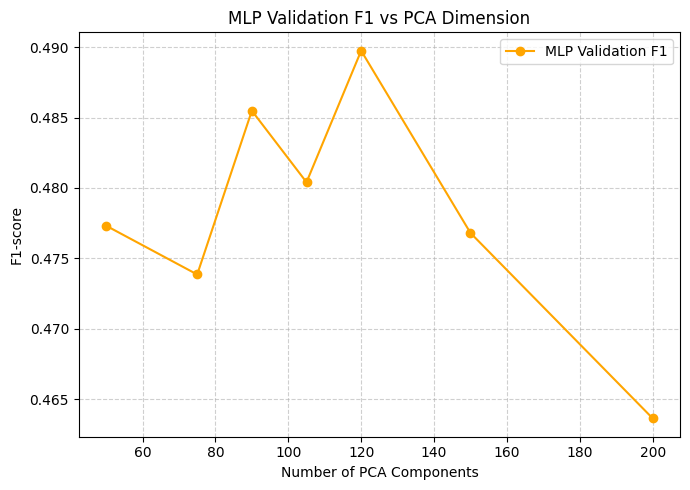


[INFO] Best PCA Dimension (MLP): 120


In [173]:
# ================================================================
# PCA Dimension Scan (MLP Version)
# ================================================================
print("++++++++++++++")
print("\n[INFO] Evaluating PCA dimension sizes with MLP")
print("++++++++++++++")

dims = [50, 75, 90, 105, 120, 150, 200]
results_pca_mlp = []

for d in dims:
    print(f"\n--- Evaluating PCA with {d} components ---")
    pca = PCA(n_components=d, svd_solver="randomized", whiten=True, random_state=42)
    
    pipe, f1 = build_and_evaluate_pipeline(
        X_train_clean, y_train_valid,
        X_val_clean, y_val_valid,
        estimator=base_mlp,
        model_name="MLP",
        reducer=pca,
        reducer_name="pca"
    )
    
    results_pca_mlp.append((d, f1))

# Plot F1 vs PCA Dimension for MLP
plt.figure(figsize=(7,5))
plt.plot([d for d, _ in results_pca_mlp], [f for _, f in results_pca_mlp],
         marker="o", color="orange", label="MLP Validation F1")
plt.xlabel("Number of PCA Components")
plt.ylabel("F1-score")
plt.title("MLP Validation F1 vs PCA Dimension")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Select best PCA dimension for MLP
best_dim_mlp = max(results_pca_mlp, key=lambda x: x[1])[0]
print(f"\n[INFO] Best PCA Dimension (MLP): {best_dim_mlp}")

# === Manual Grid Search Results (MLP) ===

Best Parameters: layers=(512, 256), alpha=0.0001

Best Validation F1: 0.5306




In [174]:
# Manual Grid Search on MLP Hyperparameters (with SelectKBest k=500)
# ================================================================

print("\n[INFO] Manual Grid Search over MLP parameters (layers, alpha)...")

from sklearn.neural_network import MLPClassifier

param_grid = {
    "hidden_layer_sizes": [
        (256, 128),            
        (256, 128, 64),        
        (512, 256),            
        (512, 256, 128)        
    ],
    "alpha": [1e-5, 1e-4, 1e-2],  
    "learning_rate_init": [1e-4, 1e-3], 
    "batch_size": [32, 64]               
}

best_f1 = -1
best_params = None
results_grid = []

# Apply SelectKBest (fixed k=500)
sel = SelectKBest(f_classif, k=best_k_MLP)
X_train_sel = sel.fit_transform(X_train_clean, y_train_valid)
X_val_sel   = sel.transform(X_val_clean)

for layers in param_grid["hidden_layer_sizes"]:
    for alpha in param_grid["alpha"]:
        for lr in param_grid["learning_rate_init"]:
            for bs in param_grid["batch_size"]:
                print(f"Testing layers={layers}, alpha={alpha}, lr={lr}, batch={bs} ...")

                base_mlp = MLPClassifier(
                    hidden_layer_sizes=layers,
                    activation="relu",
                    solver="adam",
                    alpha=alpha,
                    batch_size=bs,
                    learning_rate_init=lr,
                    max_iter=200,
                    early_stopping=True,
                    random_state=42
                )

                pipe, f1 = build_and_evaluate_pipeline(
                    X_train_sel, y_train_valid,
                    X_val_sel, y_val_valid,
                    estimator=base_mlp,
                    model_name="MLP"
                )

                results_grid.append((layers, alpha, lr, bs, f1))
                if f1 > best_f1:
                    best_f1 = f1
                    best_params = (layers, alpha, lr, bs)
                    best_model = pipe

print("\n=== Manual Grid Search Results (MLP) ===")
print(f"Best Parameters: layers={best_params[0]}, alpha={best_params[1]}")
print(f"Best Validation F1: {best_f1:.4f}")

# Convert results to DataFrame
df_grid_mlp = pd.DataFrame(results_grid, columns=["layers", "alpha", "lr", "batch", "F1"])



[INFO] Manual Grid Search over MLP parameters (layers, alpha)...
Testing layers=(256, 128), alpha=1e-05, lr=0.0001, batch=32 ...

[MLP] Validation f1_weighted: 0.5076
Testing layers=(256, 128), alpha=1e-05, lr=0.0001, batch=64 ...

[MLP] Validation f1_weighted: 0.5105
Testing layers=(256, 128), alpha=1e-05, lr=0.001, batch=32 ...

[MLP] Validation f1_weighted: 0.4918
Testing layers=(256, 128), alpha=1e-05, lr=0.001, batch=64 ...

[MLP] Validation f1_weighted: 0.4992
Testing layers=(256, 128), alpha=0.0001, lr=0.0001, batch=32 ...

[MLP] Validation f1_weighted: 0.5083
Testing layers=(256, 128), alpha=0.0001, lr=0.0001, batch=64 ...

[MLP] Validation f1_weighted: 0.5090
Testing layers=(256, 128), alpha=0.0001, lr=0.001, batch=32 ...

[MLP] Validation f1_weighted: 0.4973
Testing layers=(256, 128), alpha=0.0001, lr=0.001, batch=64 ...

[MLP] Validation f1_weighted: 0.4992
Testing layers=(256, 128), alpha=0.01, lr=0.0001, batch=32 ...

[MLP] Validation f1_weighted: 0.5121
Testing layers=(2


=== Top 5 MLP Configurations by Validation F1 ===
                                       config       F1
  L=(512, 256) | α=0.0001 | lr=0.0001 | bs=32 0.529826
    L=(512, 256) | α=0.01 | lr=0.0001 | bs=32 0.529073
   L=(512, 256) | α=1e-05 | lr=0.0001 | bs=32 0.526243
L=(512, 256, 128) | α=0.01 | lr=0.001 | bs=32 0.526223
    L=(512, 256) | α=0.01 | lr=0.0001 | bs=64 0.522988


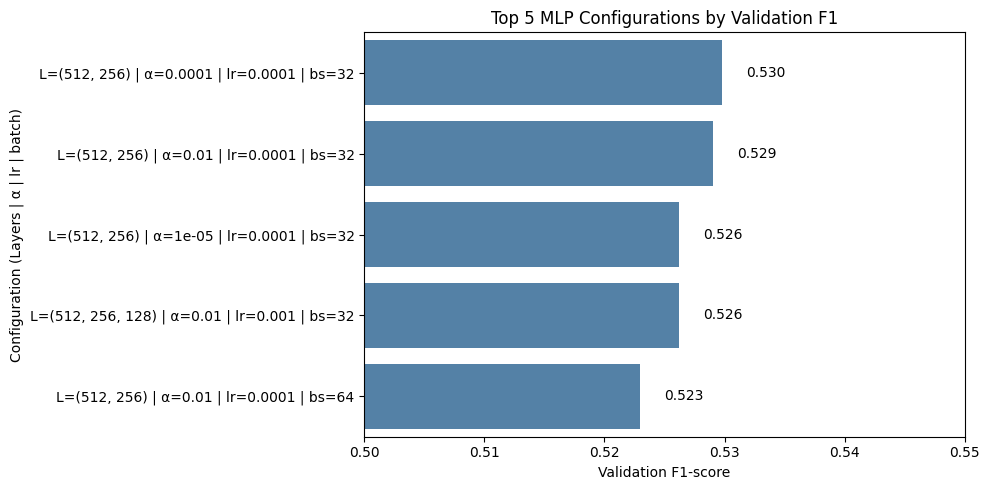

In [180]:

df_grid_mlp["layers"] = df_grid_mlp["layers"].astype(str)
# Visualization 1: Heatmap (Layer × Alpha)
# ================================================================
# --- Sort by F1 and select top 5 ---
df_top5 = df_grid_mlp.sort_values(by="F1", ascending=False).head(5)

# --- Create readable label combining all hyperparameters ---
df_top5["config"] = (
    "L=" + df_top5["layers"] +
    " | α=" + df_top5["alpha"].astype(str) +
    " | lr=" + df_top5["lr"].astype(str) +
    " | bs=" + df_top5["batch"].astype(str)
)

# --- Print for verification ---
print("\n=== Top 5 MLP Configurations by Validation F1 ===")
print(df_top5[["config", "F1"]].to_string(index=False))

# --- Plot ---
plt.figure(figsize=(10,5))
sns.barplot(
    data=df_top5,
    x="F1",
    y="config",
    color="steelblue"
)

# Add F1 labels at end of bars
for i, f1 in enumerate(df_top5["F1"]):
    plt.text(f1 + 0.002, i, f"{f1:.3f}", va="center")

plt.title("Top 5 MLP Configurations by Validation F1")
plt.xlabel("Validation F1-score")
plt.xlim(0.5,0.55)
plt.ylabel("Configuration (Layers | α | lr | batch)")
plt.tight_layout()
plt.show()

=== Test Set Summary (MLP) ===

Overall Accuracy         : 0.5471

Balanced Accuracy        : 0.5114

Weighted F1-score        : 0.5395


[INFO] Evaluating best MLP model on the test set

=== Test Set Summary (MLP) ===
Overall Accuracy         : 0.5471
Balanced Accuracy        : 0.5114
Weighted F1-score        : 0.5395

--- Per-Class Performance (MLP) ---
              Precision  Recall      F1  Support
angry            0.4457  0.3697  0.4041    422.0
disgust          0.5946  0.4783  0.5301     46.0
fear             0.4051  0.2741  0.3269    467.0
happy            0.7199  0.8029  0.7591    842.0
sad              0.3905  0.4749  0.4286    518.0
surprise         0.6667  0.6598  0.6632    388.0
neutral          0.4976  0.5200  0.5086    600.0
macro avg        0.5314  0.5114  0.5172   3283.0
weighted avg     0.5392  0.5471  0.5395   3283.0


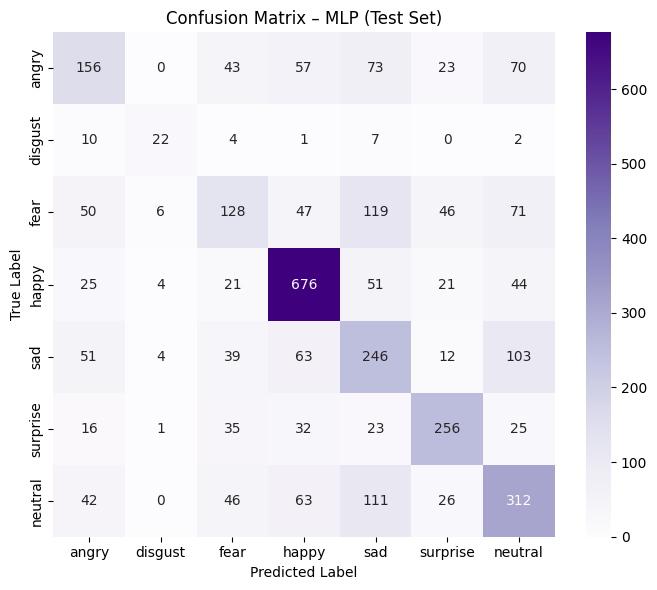

In [181]:
# ================================================================
# Final Evaluation on Test Set (MLP + SelectKBest k=500)
# ================================================================

print("\n[INFO] Evaluating best MLP model on the test set")

# --- Apply the same feature selector used in training ---
X_test_sel = sel.transform(X_test_clean)
yte = y_test_valid

# --- Prediction ---
yte_pred = best_model.predict(X_test_sel)

# --- Metrics ---
acc = accuracy_score(yte, yte_pred)
bal_acc = balanced_accuracy_score(yte, yte_pred)
f1_weighted = f1_score(yte, yte_pred, average="weighted")

print("\n=== Test Set Summary (MLP) ===")
print(f"{'Overall Accuracy':<25}: {acc:.4f}")
print(f"{'Balanced Accuracy':<25}: {bal_acc:.4f}")
print(f"{'Weighted F1-score':<25}: {f1_weighted:.4f}")

# --- Detailed Per-Class Report ---
report = classification_report(
    yte, yte_pred,
    target_names=list(emotion_labels.values()),
    output_dict=True
)

df_report = pd.DataFrame(report).T
df_report = df_report.rename(columns={
    "precision": "Precision",
    "recall": "Recall",
    "f1-score": "F1",
    "support": "Support"
}).round(4)
df_report = df_report.drop(index="accuracy", errors="ignore")

print("\n--- Per-Class Performance (MLP) ---")
print(df_report.to_string())

# --- Confusion Matrix ---
plt.figure(figsize=(7,6))
sns.heatmap(
    confusion_matrix(yte, yte_pred),
    annot=True, fmt="d", cmap="Purples",
    xticklabels=emotion_labels.values(),
    yticklabels=emotion_labels.values()
)
plt.title("Confusion Matrix – MLP (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()



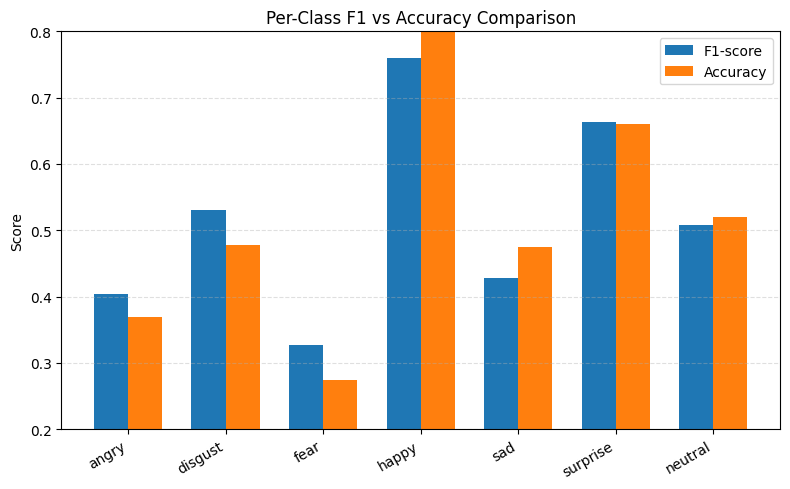

In [182]:
# ===============================================================
# Visualization: Per-Class F1 vs Accuracy Comparison
# ===============================================================

# --- Compute per-class accuracy (TP / total true samples) ---
cm = confusion_matrix(yte, yte_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

# --- 構建 DataFrame ---
df_vis = pd.DataFrame({
    "Emotion": list(emotion_labels.values()),
    "F1": df_report.loc[list(emotion_labels.values()), "F1"].values,
    "Accuracy": per_class_acc
}).round(4)

# --- 畫出比較圖 ---
plt.figure(figsize=(8,5))
x = np.arange(len(df_vis))
bar_width = 0.35

plt.bar(x - bar_width/2, df_vis["F1"], width=bar_width, label="F1-score")
plt.bar(x + bar_width/2, df_vis["Accuracy"], width=bar_width, label="Accuracy")

plt.xticks(x, df_vis["Emotion"], rotation=30, ha="right")
plt.ylabel("Score")
plt.ylim(0.2, 0.8)
plt.title("Per-Class F1 vs Accuracy Comparison")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [183]:
# ================================================================
# Save Best Model and Feature Selector
# ================================================================

os.makedirs("models", exist_ok=True)

# Save both model and feature selector
layers_best, alpha_best, lr_best, bs_best = best_params
model_path = f"models/best_mlp_k500_L{layers_best}_A{alpha_best}_LR{lr_best}_B{bs_best}.joblib"
joblib.dump(best_model, model_path)
joblib.dump(sel, "models/selectkbest_500.joblib")

print(f"\nBest MLP model saved successfully at: {model_path}")
print("Feature selector saved at: models/selectkbest_500.joblib")


Best MLP model saved successfully at: models/best_mlp_k500_L(512, 256)_A0.0001_LR0.0001_B32.joblib
Feature selector saved at: models/selectkbest_500.joblib


# Gabiele Random Forest

In [ ]:

# Imports for the additions (kept separate to avoid touching previous cells)
from pathlib import Path
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
)

# Try importing SMOTE; provide a clear hint if it's missing.
try:
    from imblearn.over_sampling import SMOTE
except Exception as e:
    raise ImportError(
        "imblearn (imbalanced-learn) is not installed. Please install with "
        "`pip install imbalanced-learn` and re-run this cell."
    ) from e

# Ensure label map exists (fallback if needed)
if 'emotion_labels' not in globals():
    emotion_labels = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "sad", 5: "surprise", 6: "neutral"}

# Ensure models/artifacts folders exist
MODELS_DIR = Path("models"); MODELS_DIR.mkdir(exist_ok=True)
ARTIFACTS_DIR = Path("artifacts"); ARTIFACTS_DIR.mkdir(exist_ok=True)


In [ ]:

# Sanity checks to avoid surprises
required = ['X_train_hog','y_train','X_val_hog','y_val','X_test_hog','y_test']
missing = [v for v in required if v not in globals()]
assert not missing, f"Missing variables from previous cells: {missing}. Please run the earlier notebook cells."
print("Environment OK — proceeding with SMOTE + RF variants.")


In [ ]:

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_hog_sm, y_train_sm = smote.fit_resample(X_train_hog, y_train)

# Quick class count check (optional)
_, counts_before = np.unique(y_train, return_counts=True)
_, counts_after  = np.unique(y_train_sm, return_counts=True)
print("Class counts (train) before SMOTE:", counts_before.tolist())
print("Class counts (train) after  SMOTE:", counts_after.tolist())

# Optionally cache to speed up future runs
np.savez_compressed(ARTIFACTS_DIR / "hog_train_smote.npz", X=X_train_hog_sm, y=y_train_sm)



## 2) Random Forest — Paul's method (class-weighted on original training set)

We keep the original (imbalanced) training data and set `class_weight='balanced'`.


In [ ]:

rf_bal = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    max_features='sqrt',
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
rf_bal.fit(X_train_hog, y_train)
joblib.dump(rf_bal, MODELS_DIR / "rf_hog_bal.pkl")
print("Saved:", MODELS_DIR / "rf_hog_bal.pkl")



## 3) Random Forest — Gabriele's method (trained on SMOTE-balanced data)

We train on the **SMOTE**-balanced training features and **do not** use class weights.


In [ ]:

rf_smote = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    max_features='sqrt',
    class_weight=None,
    n_jobs=-1,
    random_state=42
)
rf_smote.fit(X_train_hog_sm, y_train_sm)
joblib.dump(rf_smote, MODELS_DIR / "rf_hog_smote.pkl")
print("Saved:", MODELS_DIR / "rf_hog_smote.pkl")



## 4) Evaluation helpers

We report **Accuracy**, **Balanced Accuracy**, and **Macro-F1** on **PublicTest** and **PrivateTest**, and draw confusion matrices.


In [ ]:

def _eval_split(y_true, y_pred):
    return dict(
        acc = accuracy_score(y_true, y_pred),
        balacc = balanced_accuracy_score(y_true, y_pred),
        macroF1 = f1_score(y_true, y_pred, average='macro')
    )

def _plot_cm(cm, title, labels_map):
    labels_sorted = sorted(labels_map.keys())
    names = [labels_map[i] for i in labels_sorted]
    plt.figure(figsize=(6.5, 5.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=names, yticklabels=names)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout(); plt.show()

def evaluate_model(name, model, features_val, y_val, features_test, y_test, labels_map):
    res = {}

    # PublicTest
    ypv = model.predict(features_val)
    cm_v = confusion_matrix(y_val, ypv, labels=sorted(labels_map.keys()))
    m_v = _eval_split(y_val, ypv)
    _plot_cm(cm_v, f"{name} — PublicTest", labels_map)
    res.update({f"PublicTest_{k}": v for k, v in m_v.items()})

    # PrivateTest
    ypt = model.predict(features_test)
    cm_t = confusion_matrix(y_test, ypt, labels=sorted(labels_map.keys()))
    m_t = _eval_split(y_test, ypt)
    _plot_cm(cm_t, f"{name} — PrivateTest", labels_map)
    res.update({f"PrivateTest_{k}": v for k, v in m_t.items()})

    return res



## 5) Run evaluations and build a compact comparison table

If an SVM named `svm` is available (or saved at `models/svm_model.pkl`), we include it for context.


In [ ]:

results = []

# Include SVM if present or loadable
try:
    _svm = svm  # type: ignore[name-defined]
except NameError:
    try:
        _svm = joblib.load(MODELS_DIR / "svm_model.pkl")
    except Exception:
        _svm = None

if _svm is not None:
    res_svm = evaluate_model("SVM (HOG, class-weighted)", _svm, X_val_hog, y_val, X_test_hog, y_test, emotion_labels)
    results.append({"Model": "SVM (HOG, class-weighted)", **res_svm})

# RF — Paul's method
res_rf_bal = evaluate_model("RF (HOG, class-weighted)", rf_bal, X_val_hog, y_val, X_test_hog, y_test, emotion_labels)
results.append({"Model": "RF (HOG, class-weighted)", **res_rf_bal})

# RF — Gabriele's method (SMOTE)
res_rf_sm = evaluate_model("RF (HOG, SMOTE train)", rf_smote, X_val_hog, y_val, X_test_hog, y_test, emotion_labels)
results.append({"Model": "RF (HOG, SMOTE train)", **res_rf_sm})

df_results = pd.DataFrame(results).set_index("Model")
display(df_results.sort_values("PrivateTest_balacc", ascending=False))

# Persist a CSV artifact
out_csv = ARTIFACTS_DIR / "results_rf_variants.csv"
df_results.to_csv(out_csv, float_format="%.5f")
print("Saved metrics table ->", out_csv)


## 8. Real-Time Emotion Recognition Demo
A real-time demo is created using OpenCV to:
1. Capture video frames from the webcam  
2. Detect faces using a Haar cascade  
3. Apply HOG feature extraction  
4. Predict emotion using the trained SVM model

In [179]:
!python demo_emotion.py

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
[INFO] Real-time emotion recognition started. Press 'q' to quit.
[INFO] Webcam released and windows closed.
Traceback (most recent call last):
  File "/Users/pck/TUe_AI_ES/2025_Q1/Dataanalysis_and_learningmethods/ml_emotion_recognition/demo_emotion.py", line 119, in <module>
    main()
  File "/Users/pck/TUe_AI_ES/2025_Q1/Dataanalysis_and_learningmethods/ml_emotion_recognition/demo_emotion.py", line 97, in main
    pred = int(model.predict(feat_clean)[0])
  File "/opt/miniconda3/envs/emotion_reg/lib/python3.10/site-packages/sklearn/pipeline.py", line 600, in predict
    Xt = transform.transform(Xt)
  File "/opt/miniconda3/envs/emotion_reg/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/opt/miniconda3/envs/emotion_reg/lib/python3.10/site-packages/sklearn/preprocessing/_data.py", line 1045, in transform
    X = self._validate_data(
  File "/opt/